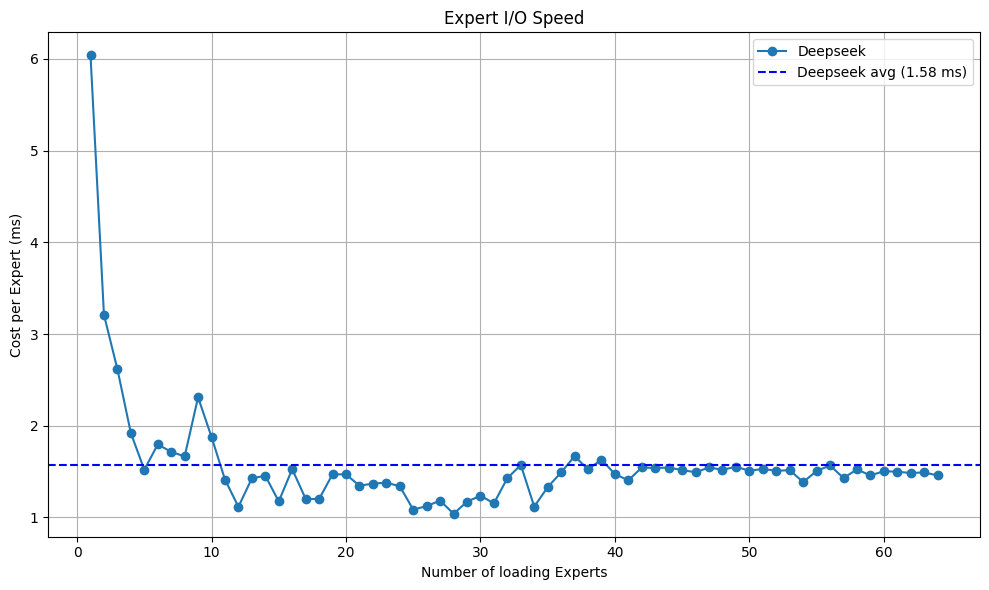

In [ ]:
import re
import matplotlib.pyplot as plt

# 日志文件路径
log_file = "/home/fit/renju/WORK/lxm/tmp.log"

# 定义两个列表，分别用于存储 Deepseek 和 OLMOE 部分的 (experts, cost_per_expert)
deepseek_experts = []
deepseek_cost = []

olmoe_experts = []
olmoe_cost = []

# 当前处理的Section，默认为None
current_section = None

with open(log_file, "r") as f:
    for line in f:
        line = line.strip()
        # 判断区段切换
        if line == "Deepseek":
            current_section = "Deepseek"
            continue
        elif line == "OLMOE":
            current_section = "OLMOE"
            continue
        
        # 匹配格式： test_offload: load {num} experts cost {time} ms
        m = re.search(r"load\s+(\d+)\s+experts\s+cost\s+([\d\.]+)\s+ms", line)
        if m:
            experts = int(m.group(1))
            cost = float(m.group(2))
            cost_per_expert = cost / experts
            if current_section == "Deepseek":
                deepseek_experts.append(experts)
                deepseek_cost.append(cost_per_expert)
            elif current_section == "OLMOE":
                olmoe_experts.append(experts)
                olmoe_cost.append(cost_per_expert)

# 绘制折线图
plt.figure(figsize=(10,6))
if deepseek_experts:
    plt.plot(deepseek_experts, deepseek_cost, marker='o', label="Deepseek")
    avg_deepseek = sum(deepseek_cost) / len(deepseek_cost)
    plt.axhline(y=avg_deepseek, color='blue', linestyle='--', 
                label=f"Deepseek avg ({avg_deepseek:.2f} ms)")
if olmoe_experts:
    plt.plot(olmoe_experts, olmoe_cost, marker='s', label="OLMOE")
    avg_olmoe = sum(olmoe_cost) / len(olmoe_cost)
    plt.axhline(y=avg_olmoe, color='orange', linestyle='--', 
                label=f"OLMOE avg ({avg_olmoe:.2f} ms)")

plt.xlabel("Number of loading Experts")
plt.ylabel("Cost per Expert (ms)")
plt.title("Expert I/O Speed")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
import os
import time
import json
import torch
from safetensors import safe_open
from safetensors.torch import save_file
from collections import defaultdict

def test_io_bandwidth():
    # 1. 配置文件路径
    index_path = "/home/fit/renju/WORK/lxm/models/Mixtral_8x7B_v0_1/model.safetensors.index.json"
    data_dir = os.path.dirname(index_path)
    
    # 2. 加载索引文件
    with open(index_path) as f:
        index = json.load(f)
    
    # 3. 提取所有experts相关键并按文件分组
    expert_keys = [k for k in index["weight_map"] if k.startswith("model.layers.1.block_sparse_moe.experts")]
    
    # 创建文件到键的映射
    file_to_keys = defaultdict(list)
    for key in expert_keys:
        file_name = index["weight_map"][key]
        file_to_keys[file_name].append(key)
    
    # 4. 测试读取带宽
    expert_tensors = {}
    total_bytes = 0
    read_start = time.time()
    
    for file_name, keys in file_to_keys.items():
        file_path = os.path.join(data_dir, file_name)
        with safe_open(file_path, framework="pt", device="cpu") as f:
            for key in keys:
                tensor = f.get_tensor(key)
                expert_tensors[key] = tensor
                total_bytes += tensor.numel() * 2  # bfloat16 = 2 bytes
    
    read_time = time.time() - read_start
    read_bandwidth = total_bytes / read_time / (1024**3)  # GB/s
    
    # 5. 测试写入带宽（写入单个文件）
    temp_file = "/tmp/expert_weights.safetensors"
    write_start = time.time()
    save_file(expert_tensors, temp_file)
    write_time = time.time() - write_start
    write_bandwidth = total_bytes / write_time / (1024**3)  # GB/s
    
    # 6. 清理
    os.remove(temp_file)
    
    return {
        "total_bytes": total_bytes,
        "total_gb": total_bytes / (1024**3),
        "num_tensors": len(expert_tensors),
        "num_files": len(file_to_keys),
        "read_time": read_time,
        "read_bandwidth": read_bandwidth,
        "write_time": write_time,
        "write_bandwidth": write_bandwidth,
        "file_distribution": {k: len(v) for k, v in file_to_keys.items()}
    }

def run_multiple_tests(n=5):
    read_results = []
    write_results = []
    read_time_results = []
    write_time_results = []
    tensors_count = 0
    gb = 0

    
    for _ in range(n):
        results = test_io_bandwidth()
        read_results.append(results['read_bandwidth'])
        write_results.append(results['write_bandwidth'])
        read_time_results.append(results['read_time'])
        write_time_results.append(results['write_time'])
        tensors_count+= results['num_tensors']
        gb+= results['total_gb']


    
    avg_read = sum(read_results) / n
    avg_write = sum(write_results) / n
    
    print(f"Average read bandwidth ({n} runs): {avg_read:.3f} GB/s")
    print(f"Average write bandwidth ({n} runs): {avg_write:.3f} GB/s")
    print(f"Average read time ({n} runs): {sum(read_time_results) / n:.3f} seconds")
    print(f"Average write time ({n} runs): {sum(write_time_results) / n:.3f} seconds")
    print(f"Total tensors processed: {tensors_count/3}")  
    print(f"Total GB processed: {gb*1024/8:.3f} MB")

if __name__ == "__main__":
   run_multiple_tests(5)  # 默认运行 5 次测试

Average read bandwidth (5 runs): 667.146 GB/s
Average write bandwidth (5 runs): 0.507 GB/s
Average read time (5 runs): 0.004 seconds
Average write time (5 runs): 5.175 seconds
Total tensors processed: 40.0
Total GB processed: 1680.000 MB


成功读取 Cache_hit_ratio_0.125: 32 层数据
  Layer range: 0 - 31
  Hit rate range: 0.1359 - 0.4413
成功读取 Cache_hit_ratio_0.25: 32 层数据
  Layer range: 0 - 31
  Hit rate range: 0.2835 - 0.6630
成功读取 Cache_hit_ratio_0.5: 32 层数据
  Layer range: 0 - 31
  Hit rate range: 0.5576 - 0.8926
图形已保存到: ./layer_hit_rates_comparison.svg


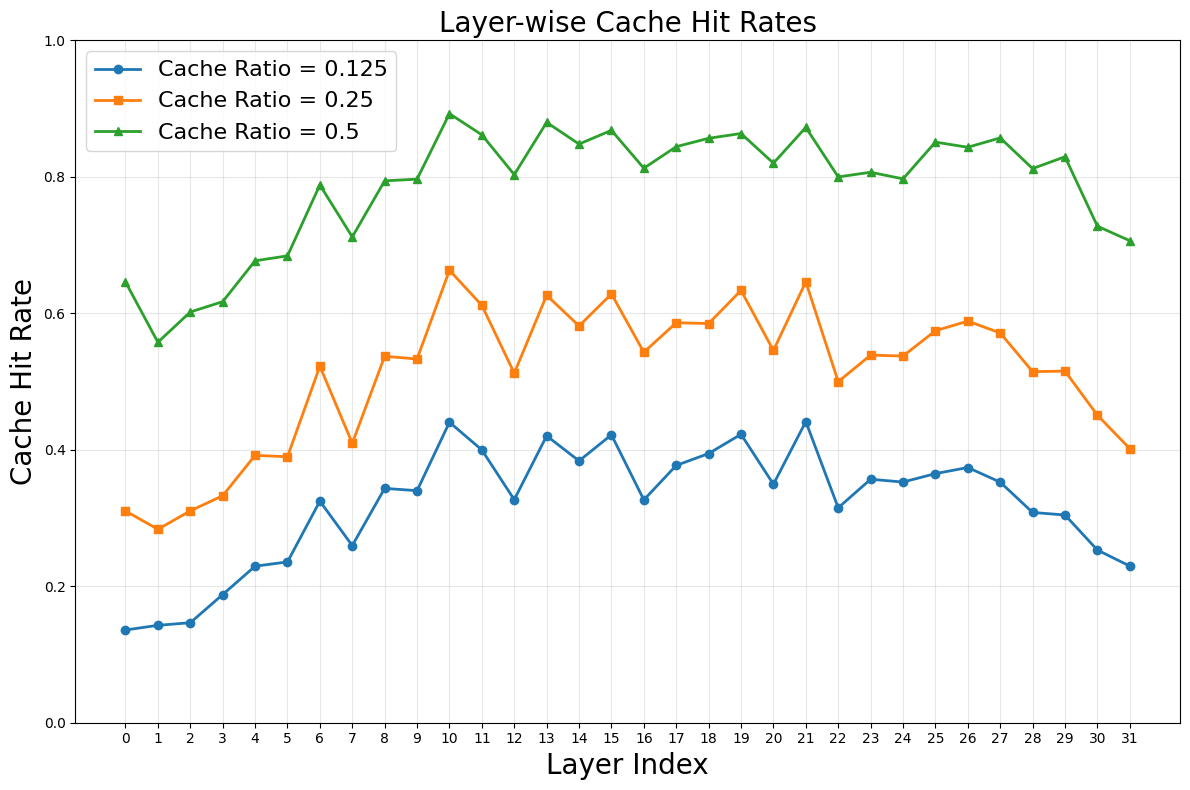


=== LRU_REAL 策略各层命中率统计 ===

Cache_hit_ratio_0.125:
  Layer 0: 0.1359
  Layer 1: 0.1427
  Layer 2: 0.1466
  Layer 3: 0.1878
  Layer 4: 0.2294
  Layer 5: 0.2356
  Layer 6: 0.3247
  Layer 7: 0.2596
  Layer 8: 0.3434
  Layer 9: 0.3401
  Layer 10: 0.4404
  Layer 11: 0.3997
  Layer 12: 0.3269
  Layer 13: 0.4204
  Layer 14: 0.3837
  Layer 15: 0.4219
  Layer 16: 0.3266
  Layer 17: 0.3770
  Layer 18: 0.3945
  Layer 19: 0.4227
  Layer 20: 0.3495
  Layer 21: 0.4413
  Layer 22: 0.3150
  Layer 23: 0.3568
  Layer 24: 0.3527
  Layer 25: 0.3650
  Layer 26: 0.3740
  Layer 27: 0.3526
  Layer 28: 0.3081
  Layer 29: 0.3044
  Layer 30: 0.2530
  Layer 31: 0.2296
  平均命中率: 0.3207

Cache_hit_ratio_0.25:
  Layer 0: 0.3103
  Layer 1: 0.2835
  Layer 2: 0.3104
  Layer 3: 0.3327
  Layer 4: 0.3918
  Layer 5: 0.3898
  Layer 6: 0.5225
  Layer 7: 0.4096
  Layer 8: 0.5369
  Layer 9: 0.5330
  Layer 10: 0.6630
  Layer 11: 0.6116
  Layer 12: 0.5122
  Layer 13: 0.6264
  Layer 14: 0.5815
  Layer 15: 0.6284
  Layer 16: 0.542

In [16]:
def plot_layer_hit_rates_comparison(
    base_path="/home/fit/renju/WORK/lxm/Analyse/results_hot/figures",
    model_name="deepseek_v2_lite",
    dataset="alpaca",
    cache_hit_ratios=None,
    strategy="lru",
    save_path=None,
    figsize=(12, 8),
    colors=None,
    markers=None,
    title="Layer-wise Cache Hit Rates Comparison"
):
    """
    比较不同Cache_hit_ratio条件下，指定策略在各层的hit_rates
    
    Parameters:
        base_path (str): 基础路径
        model_name (str): 模型名称
        dataset (str): 数据集名称
        cache_hit_ratios (list): 缓存命中率列表，如果为None则使用默认值
        strategy (str): 缓存策略名称
        save_path (str): 保存路径，如果为None则不保存
        figsize (tuple): 图形大小
        colors (list): 颜色列表，用于不同cache_hit_ratio的折线
        markers (list): 标记列表，用于不同cache_hit_ratio的折线
        title (str): 图表标题
    
    Returns:
        dict: {cache_hit_ratio: (layers, hit_rates)} 所有数据
    """
    import json
    import os
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 默认值
    if cache_hit_ratios is None:
        cache_hit_ratios = ["0.125", "0.25"]
    
    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    if markers is None:
        markers = ['o', 's', '^', 'D', 'v', '<']
    
    # 存储所有数据
    all_data = {}
    
    # 创建图形
    plt.figure(figsize=figsize)
    
    # 为每个cache_hit_ratio绘制一条折线
    for idx, cache_hit_ratio in enumerate(cache_hit_ratios):
        # 构建文件路径
        file_path = os.path.join(
            base_path, model_name, dataset, 
            f"Cache_hit_ratio_{cache_hit_ratio}", f"{dataset}.json"
        )
        
        try:
            # 读取JSON文件
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # 提取指定策略的hit_rates
            if strategy not in data:
                print(f"策略 '{strategy}' 在文件 {file_path} 中未找到")
                continue
                
            hit_rates_dict = data[strategy]["hit_rates"]
            
            # 将层编号和命中率分别提取并排序
            layers = []
            hit_rates = []
            
            for layer_str, hit_rate in hit_rates_dict.items():
                layer_num = int(layer_str)
                layers.append(layer_num)
                hit_rates.append(hit_rate)
            
            # 按层编号排序
            sorted_data = sorted(zip(layers, hit_rates))
            layers, hit_rates = zip(*sorted_data)
            
            # 存储数据
            all_data[cache_hit_ratio] = (layers, hit_rates)
            
            # 绘制折线
            color = colors[idx % len(colors)]
            marker = markers[idx % len(markers)]
            
            # 创建标签
            label = f'Cache Ratio = {cache_hit_ratio}'
            
            plt.plot(layers, hit_rates, 
                    color=color, 
                    marker=marker, 
                    linewidth=2, 
                    markersize=6,
                    label=label)
            
            # 添加数值标签（可选，如果层数不多的话）
            if len(layers) <= 10:
                for x, y in zip(layers, hit_rates):
                    plt.annotate(f'{y:.3f}', (x, y), 
                                textcoords="offset points", 
                                xytext=(0, 10 + idx * 5), 
                                ha='center',
                                fontsize=8,
                                color=color)
            
            print(f"成功读取 Cache_hit_ratio_{cache_hit_ratio}: {len(layers)} 层数据")
            print(f"  Layer range: {min(layers)} - {max(layers)}")
            print(f"  Hit rate range: {min(hit_rates):.4f} - {max(hit_rates):.4f}")
            
        except FileNotFoundError:
            print(f"文件未找到: {file_path}")
            continue
        except KeyError as e:
            print(f"数据格式错误，缺少键: {e} in {file_path}")
            continue
        except json.JSONDecodeError:
            print(f"JSON格式错误: {file_path}")
            continue
    
    if not all_data:
        print("没有找到任何有效数据，无法绘图")
        return {}
    
    # 设置图表属性
    plt.xlabel('Layer Index', fontsize=20)
    plt.ylabel('Cache Hit Rate', fontsize=20)
    plt.title(title, fontsize=20)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=16)
    
    # 设置轴
    all_layers = sorted(set([layer for data in all_data.values() for layer in data[0]]))
    plt.xticks(all_layers)
    
    # 设置y轴范围
    all_hit_rates = [rate for data in all_data.values() for rate in data[1]]
    if all_hit_rates:
        y_min = 0.0
        y_max = 1.0
        plt.ylim(y_min, y_max)
    
    plt.tight_layout()
    
    # 保存图形为SVG
    if save_path:
        # 确保路径以.svg结尾
        if not save_path.endswith('.svg'):
            save_path = save_path.rsplit('.', 1)[0] + '.svg'
        
        plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
        print(f"图形已保存到: {save_path}")
    
    plt.show()
    
    # 打印统计信息
    print(f"\n=== {strategy.upper()} 策略各层命中率统计 ===")
    for cache_hit_ratio, (layers, hit_rates) in all_data.items():
        print(f"\nCache_hit_ratio_{cache_hit_ratio}:")
        for layer, hit_rate in zip(layers, hit_rates):
            print(f"  Layer {layer}: {hit_rate:.4f}")
        print(f"  平均命中率: {np.mean(hit_rates):.4f}")
    
    return all_data

# 使用示例
if __name__ == "__main__":
    # 基本用法 - 比较两个cache_hit_ratio
    layer_data = plot_layer_hit_rates_comparison(
        base_path="/home/fit/renju/WORK/lxm/Analyse/results_hot/figures",
        model_name="phi_3_5_moe_instruct",
        cache_hit_ratios=["0.125", "0.25", "0.5"],
        strategy="lru_real",
        save_path="./layer_hit_rates_comparison.svg",
        title="Layer-wise Cache Hit Rates"
    )
    
    # 扩展用法 - 比较更多cache_hit_ratio
    # layer_data = plot_layer_hit_rates_comparison(
    #     cache_hit_ratios=["0.125", "0.25", "0.5", "0.75"],
    #     strategy="lru",
    #     colors=['blue', 'red', 'green', 'purple'],
    #     markers=['o', 's', '^', 'D'],
    #     save_path="./multi_layer_comparison.svg"
    # )

Cache Ratio: Cache_hit_ratio_0.125, Ratio: 1.0, LRU Overall Hit Rate: 0.1664
Cache Ratio: Cache_hit_ratio_0.125, Ratio: 2.0, LRU Overall Hit Rate: 0.1664
Cache Ratio: Cache_hit_ratio_0.125, Ratio: 4.0, LRU Overall Hit Rate: 0.1664
Cache Ratio: Cache_hit_ratio_0.125, Ratio: 6.0, LRU Overall Hit Rate: 0.1664
Cache Ratio: Cache_hit_ratio_0.25, Ratio: 1.0, LRU Overall Hit Rate: 0.4198
Cache Ratio: Cache_hit_ratio_0.25, Ratio: 2.0, LRU Overall Hit Rate: 0.4616
Cache Ratio: Cache_hit_ratio_0.25, Ratio: 4.0, LRU Overall Hit Rate: 0.4616
Cache Ratio: Cache_hit_ratio_0.25, Ratio: 6.0, LRU Overall Hit Rate: 0.4616
Cache Ratio: Cache_hit_ratio_0.5, Ratio: 1.0, LRU Overall Hit Rate: 0.6565
Cache Ratio: Cache_hit_ratio_0.5, Ratio: 2.0, LRU Overall Hit Rate: 0.7221
Cache Ratio: Cache_hit_ratio_0.5, Ratio: 4.0, LRU Overall Hit Rate: 0.7003
Cache Ratio: Cache_hit_ratio_0.5, Ratio: 6.0, LRU Overall Hit Rate: 0.7003
Cache Ratio: Cache_hit_ratio_0.75, Ratio: 1.0, LRU Overall Hit Rate: 0.8441
Cache Ratio:

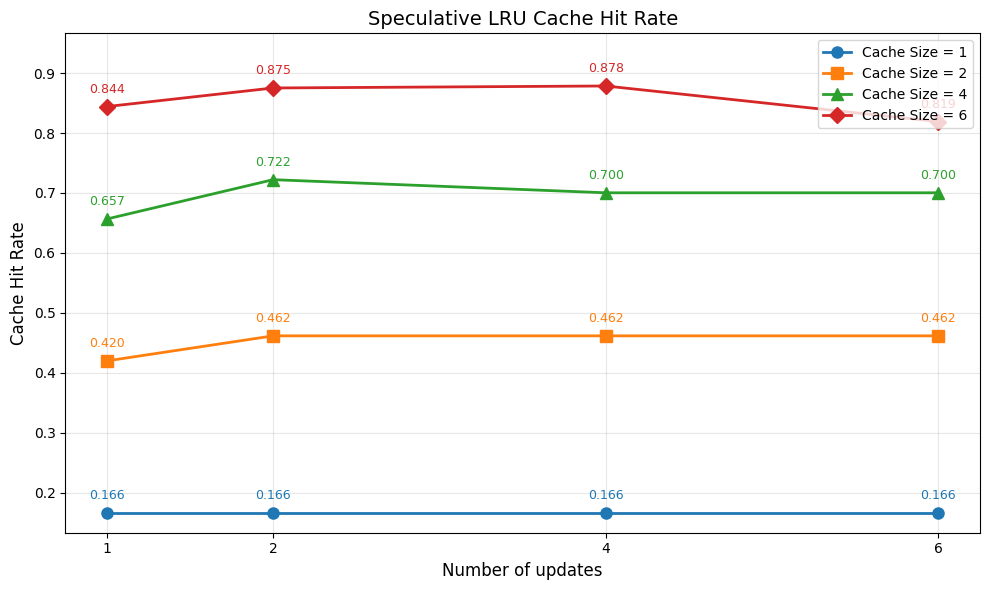


=== LRU 策略统计信息 ===

Cache_hit_ratio_0.125:
  Ratio: 1.0 -> Overall Hit Rate: 0.1664
  Ratio: 2.0 -> Overall Hit Rate: 0.1664
  Ratio: 4.0 -> Overall Hit Rate: 0.1664
  Ratio: 6.0 -> Overall Hit Rate: 0.1664

Cache_hit_ratio_0.25:
  Ratio: 1.0 -> Overall Hit Rate: 0.4198
  Ratio: 2.0 -> Overall Hit Rate: 0.4616
  Ratio: 4.0 -> Overall Hit Rate: 0.4616
  Ratio: 6.0 -> Overall Hit Rate: 0.4616

Cache_hit_ratio_0.5:
  Ratio: 1.0 -> Overall Hit Rate: 0.6565
  Ratio: 2.0 -> Overall Hit Rate: 0.7221
  Ratio: 4.0 -> Overall Hit Rate: 0.7003
  Ratio: 6.0 -> Overall Hit Rate: 0.7003

Cache_hit_ratio_0.75:
  Ratio: 1.0 -> Overall Hit Rate: 0.8441
  Ratio: 2.0 -> Overall Hit Rate: 0.8751
  Ratio: 4.0 -> Overall Hit Rate: 0.8785
  Ratio: 6.0 -> Overall Hit Rate: 0.8190


In [11]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_lru_hit_rate_vs_ratio(
    base_path="/home/fit/renju/WORK/lxm/Analyse/results_ab_pre_ratio",
    ratios=None,
    cache_hit_ratios=None,
    model_name="deepseek_v2_lite",
    dataset="alpaca",
    strategy="lru",
    save_path=None,
    figsize=(10, 6),
    colors=None,
    markers=None,
    title="LRU Cache Hit Rate vs Ratio",
):
    """
    比较在不同Cache_hit_ratio条件下，指定策略的overall_hit_rate随ratio变化的情况
    
    Parameters:
        base_path (str): 基础路径
        ratios (list): ratio值列表，如果为None则使用默认值
        cache_hit_ratios (list): 缓存命中率列表，如果为None则使用默认值
        model_name (str): 模型名称
        dataset (str): 数据集名称
        strategy (str): 缓存策略名称
        save_path (str): 保存路径，如果为None则不保存
        figsize (tuple): 图形大小
        colors (list): 颜色列表，用于不同cache_hit_ratio的折线
        markers (list): 标记列表，用于不同cache_hit_ratio的折线
    
    Returns:
        dict: {cache_hit_ratio: (ratio_values, hit_rates)} 所有数据
    """
    # 默认值
    if ratios is None:
        ratios = ["ratio_2", "ratio_4", "ratio_12", "ratio_18"]
    
    if cache_hit_ratios is None:
        cache_hit_ratios = ["Cache_hit_ratio_0.25", "Cache_hit_ratio_0.5", "Cache_hit_ratio_0.75"]
    
    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    if markers is None:
        markers = ['o', 's', '^', 'D', 'v', '<']
    
    # 存储所有数据
    all_data = {}
    
    # 创建图形
    plt.figure(figsize=figsize)
    
    # 为每个cache_hit_ratio绘制一条折线
    for idx, cache_hit_ratio in enumerate(cache_hit_ratios):
        ratio_values = []
        hit_rates = []
        
        # 读取每个ratio对应的文件
        for ratio_dir in ratios:
            file_path = os.path.join(
                base_path, ratio_dir, "figures", model_name, 
                dataset, cache_hit_ratio, f"{dataset}.json"
            )
            
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                
                # 提取ratio数值
                ratio_value = float(ratio_dir.split('_')[-1])*2
                ratio_values.append(ratio_value)
                
                # 提取指定策略的overall_hit_rate
                hit_rate = data[strategy]["overall_hit_rate"]
                hit_rates.append(hit_rate)
                
                print(f"Cache Ratio: {cache_hit_ratio}, Ratio: {ratio_value}, "
                      f"{strategy.upper()} Overall Hit Rate: {hit_rate:.4f}")
                
            except FileNotFoundError:
                print(f"文件未找到: {file_path}")
                continue
            except KeyError as e:
                print(f"数据格式错误，缺少键: {e} in {file_path}")
                continue
        
        if not ratio_values:
            print(f"没有找到 {cache_hit_ratio} 的有效数据")
            continue
        
        # 按ratio值排序
        sorted_data = sorted(zip(ratio_values, hit_rates))
        ratio_values, hit_rates = zip(*sorted_data)
        
        # 存储数据
        all_data[cache_hit_ratio] = (ratio_values, hit_rates)
        
        # 绘制折线
        color = colors[idx % len(colors)]
        marker = markers[idx % len(markers)]
        
        # 提取显示标签
        cache_ratio_value = cache_hit_ratio.replace("Cache_hit_ratio_", "")
        label = f'Cache Size = {int(float(cache_ratio_value)*8)}'
        
        plt.plot(ratio_values, hit_rates, 
                color=color, 
                marker=marker, 
                linewidth=2, 
                markersize=8,
                label=label)
        
        # 添加数值标签
        for x, y in zip(ratio_values, hit_rates):
            plt.annotate(f'{y:.3f}', (x, y), 
                        textcoords="offset points", 
                        xytext=(0, 10 ), 
                        ha='center',
                        fontsize=9,
                        color=color)
    
    if not all_data:
        print("没有找到任何有效数据，无法绘图")
        return {}
    
    # 设置图表属性
    plt.xlabel('Number of updates', fontsize=12)
    plt.ylabel('Cache Hit Rate', fontsize=12)
    plt.title(title, 
              fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', fontsize=10)
    
    # 设置轴
    all_ratios = sorted(set([r for data in all_data.values() for r in data[0]]))
    plt.xticks(all_ratios)
    
    # 设置y轴范围
    all_hit_rates = [rate for data in all_data.values() for rate in data[1]]
    if all_hit_rates:
        y_min = min(all_hit_rates) * 0.8
        y_max = max(all_hit_rates) * 1.1
        plt.ylim(y_min, y_max)
    
    plt.tight_layout()
    
    # 保存图形为SVG
    if save_path:
        # 确保路径以.svg结尾
        if not save_path.endswith('.svg'):
            save_path = save_path.rsplit('.', 1)[0] + '.svg'
        
        plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
        print(f"图形已保存到: {save_path}")
    
    plt.show()
    
    # 打印统计信息
    print(f"\n=== {strategy.upper()} 策略统计信息 ===")
    for cache_hit_ratio, (ratio_values, hit_rates) in all_data.items():
        print(f"\n{cache_hit_ratio}:")
        for ratio, hit_rate in zip(ratio_values, hit_rates):
            print(f"  Ratio: {ratio} -> Overall Hit Rate: {hit_rate:.4f}")
    
    return all_data

# 使用示例
if __name__ == "__main__":
    # 基本用法 - 分析多个cache_hit_ratio
    all_data = plot_lru_hit_rate_vs_ratio(
        base_path="/home/fit/renju/WORK/lxm/Analyse/results_ab_pre_ratio",
        model_name="mixtral_8x7b_v0_1",
        ratios=["pre_ratio_0.5","pre_ratio_1.0", "pre_ratio_2.0", "pre_ratio_3.0"],
        cache_hit_ratios=["Cache_hit_ratio_0.125","Cache_hit_ratio_0.25", "Cache_hit_ratio_0.5", "Cache_hit_ratio_0.75"],
        strategy="lru",
        save_path="./lru_hit_rate_comparison.svg",
        title="Speculative LRU Cache Hit Rate",

    )
    
    # init: [1,2,3]

    # LRU #
    # 1: [2, 3, 1] (hit)
    # 4: [3, 1, 4] (miss, 2 evicted)

    # FIFO #
    # 1: [1, 2, 3] (hit)
    # 4: [2, 3, 4] (miss, 1 evicted)

    # LFU #
    # 1(f2,t3) -> [1(f2),2(f1),3(f1)] (hit)
    # 4(f1,t5) -> [1(f2),4(f1),3(f1)] (miss, 2 evicted)

    # Spec + LRU #
    # 1: [2, 3, 1] (hit)
    ##       PREDICT 4       ##
    ##  [3, 1, 4] (update 4) ##
    # 4: [2, 3, 4] (hit)


=== 平均值计算过程 ===

Ratio: 0.125
  Strategy: lru
    原始值: [0.16635560554823178, 0.15507029922233095, 0.15988033547594974, 0.16407439491783482, 0.15940990090879228]
    平均值: 0.16095810721462792
  Strategy: fifo
    原始值: [0.16635560554823178, 0.15507029922233095, 0.15988033547594974, 0.16407439491783482, 0.15940990090879228]
    平均值: 0.16095810721462792
  Strategy: lfu
    原始值: [0.16635560554823178, 0.15507029922233095, 0.15988033547594974, 0.16407439491783482, 0.15940990090879228]
    平均值: 0.16095810721462792
  Strategy: lru_real
    原始值: [0.04115768470224107, 0.04173211618684658, 0.04097415318503539, 0.04046815115241245, 0.041195048176940766]
    平均值: 0.041105430680695255
  Strategy: fifo_real
    原始值: [0.04114335559121912, 0.04174901503836844, 0.04093578470316337, 0.040459127421641206, 0.04115912077083105]
    平均值: 0.04108928070504464
  Strategy: lfu_real
    原始值: [0.04113619103570815, 0.041720850285832, 0.0409527119745775, 0.04044846301254791, 0.041220710609876275]
    平均值: 0.0410957853

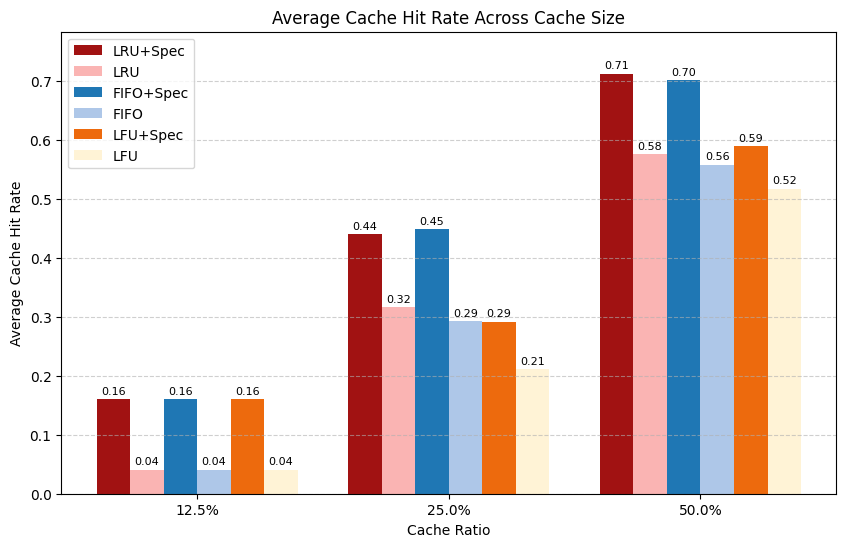

In [18]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

# --- 默认配置 ---
STRATEGY_DISPLAY_NAMES = {
    'lru': 'LRU+Spec', 'lru_real': 'LRU',
    'fifo': 'FIFO+Spec', 'fifo_real': 'FIFO',
    'lfu': 'LFU+Spec', 'lfu_real': 'LFU'
}
STRATEGY_COLORS = {
    'lru': "#A11212", 'lru_real': "#FAB4B3",
    'fifo': '#1F77B4', 'fifo_real': '#AEC7E8',
    'lfu': "#ED6A0D", 'lfu_real': "#FFF3D6"
}
STRATEGY_ORDER = ['lru', 'lru_real', 'fifo', 'fifo_real', 'lfu', 'lfu_real']

# --- 简单的加载函数 ---
def load_hit_rates(path):
    try:
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return {k: v["overall_hit_rate"] for k, v in data.items() if "overall_hit_rate" in v}
    except:
        return {}

# --- 主函数：平均 & 绘图 ---
def plot_avg_cache_hit_rate(base_dir, dataset_list, ratios, save_path=None):
    # 聚合结果: {ratio_label -> {strategy -> [values from datasets]}}
    avg_data = {ratio: {} for ratio in ratios}

    for dataset in dataset_list:
        for ratio in ratios:
            json_path = os.path.join(base_dir, dataset, f"Cache_hit_ratio_{ratio}", f"{dataset}.json")
            data = load_hit_rates(json_path)
            for strategy, value in data.items():
                avg_data[ratio].setdefault(strategy, []).append(value)

    # 计算平均值
    avg_result = {
        ratio: {
            strategy: np.mean(values)
            for strategy, values in strategies.items()
        }
        for ratio, strategies in avg_data.items()
    }

    # 打印每个ratio下每个策略的原始值和平均值
    print("=== 平均值计算过程 ===")
    for ratio, strategies in avg_data.items():
        print(f"\nRatio: {ratio}")
        for strategy, values in strategies.items():
            print(f"  Strategy: {strategy}")
            print(f"    原始值: {values}")
            print(f"    平均值: {np.mean(values)}")

    # 统一策略排序和颜色处理
    strategies_to_plot = [s for s in STRATEGY_ORDER if any(s in avg_result[r] for r in ratios)]
    num_strategies = len(strategies_to_plot)
    num_ratios = len(ratios)
    
    # --- 开始画图 ---
    all_values = []
    for strategy in strategies_to_plot:
        all_values.extend([avg_result[ratio].get(strategy, 0.0) for ratio in ratios])
    max_value = max(all_values) if all_values else 1.0


    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(num_ratios)
    total_bar_width = 0.8
    bar_width = total_bar_width / num_strategies

    for i, strategy in enumerate(strategies_to_plot):
        offset = (i - (num_strategies - 1) / 2) * bar_width
        values = [avg_result[ratio].get(strategy, 0.0) for ratio in ratios]
        color = STRATEGY_COLORS.get(strategy, f"C{i}")
        label = STRATEGY_DISPLAY_NAMES.get(strategy, strategy)

        bars = ax.bar(x + offset, values, width=bar_width, label=label, color=color)

        for bar in bars:
            height = bar.get_height()
            if height > 0.001:
                ax.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{height:.2f}",
                        ha='center', va='bottom', fontsize=8)

    ax.set_xticks(x)
    ax.set_xticklabels([f"{float(r) * 100:.1f}%" for r in ratios])
    ax.set_ylabel("Average Cache Hit Rate")
    ax.set_xlabel("Cache Ratio")
    ax.set_title("Average Cache Hit Rate Across Cache Size")
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_ylim(0, max_value*1.1)

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, format='svg', bbox_inches='tight')
        print(f"✅ 图已保存: {save_path}")

    plt.show()

# --- 执行 ---
if __name__ == "__main__":
    base_path = "/home/fit/renju/WORK/lxm/Analyse/results_hot/figures/mixtral_8x7b_v0_1"
    datasets = ["alpaca","alpaca-zh","human_eval","gsm8k","swag","squad"]
    ratios = ["0.125", "0.25", "0.5"]

    plot_avg_cache_hit_rate(
        base_dir=base_path,
        dataset_list=datasets,
        ratios=ratios,
        save_path="./average_cache_hit_rate.svg"
    )


# 环境配置

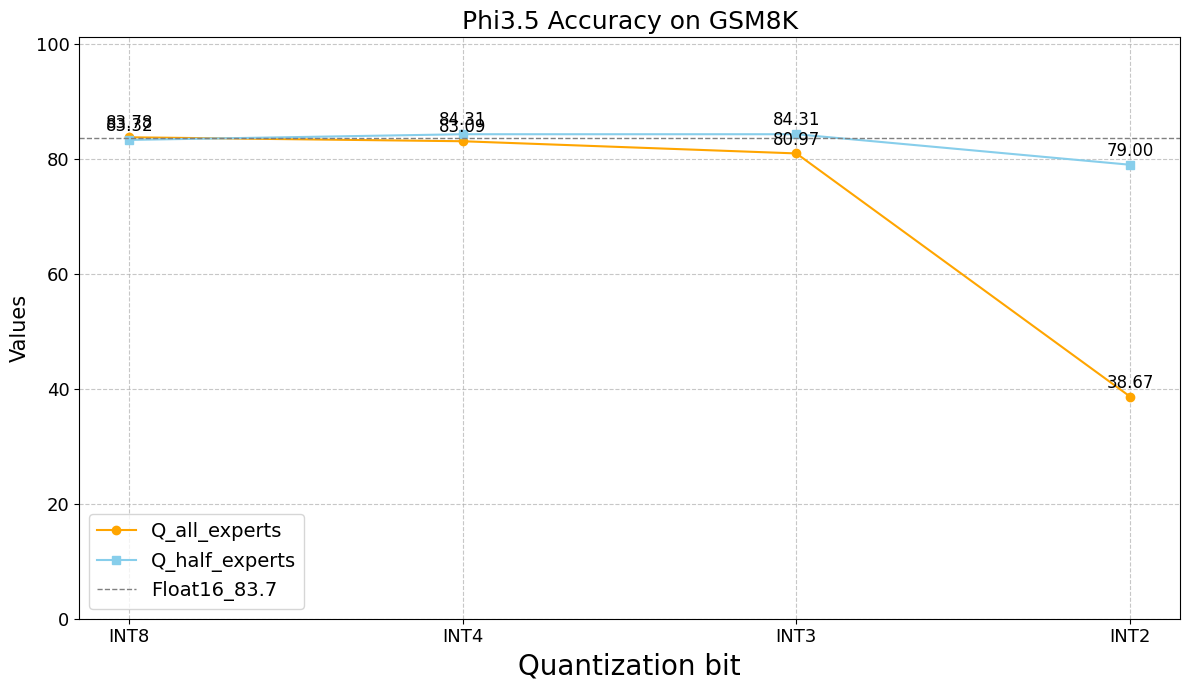

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_line_chart(
    data1, 
    data2, 
    categories=None, 
    title="Line Chart", 
    xlabel="Categories", 
    ylabel="Values", 
    color1='orange', 
    color2='skyblue',
    marker1='o',
    marker2='s',
    legend1='Group 1',
    legend2='Group 2',
    save_path=None,
    dpi=600,
    baseline=None,
):
    if categories is None:
        categories = [ "INT8", "INT4", "INT3", "INT2"]
    x = np.arange(len(categories))

    plt.figure(figsize=(12, 7))
    plt.plot(x, data1, color=color1, marker=marker1, label=legend1)
    plt.plot(x, data2, color=color2, marker=marker2, label=legend2)

    # 添加数值标签
    for i, height in enumerate(data1):
        plt.text(x[i], height + 0.01*max(data1+data2), f'{height:.2f}', ha='center', va='bottom', fontsize=12)
    for i, height in enumerate(data2):
        plt.text(x[i], height + 0.01*max(data1+data2), f'{height:.2f}', ha='center', va='bottom', fontsize=12)

    # 添加 baseline 横线
    if baseline is not None:
        plt.axhline(y=baseline, linewidth=1, label=f"Float16_{baseline}", color='gray', linestyle='--')

    plt.grid( linestyle='--', alpha=0.7)
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=15)
    plt.xticks(x, categories, fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylim(0, max(data1 + data2) * 1.2)
    plt.legend(fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format=save_path.split('.')[-1], dpi=dpi, bbox_inches="tight")
    plt.show()

# 示例用法
if __name__ == "__main__":
    # sample_data1 = [37.76, 35.94, 31.77, 10.99]
    # sample_data2 = [37.91, 37.23, 37.30, 36.39]
    # sample_data1 = [58.06,58.06,58.06,58.06]
    # sample_data2 = [58.06,58.06,58.06,58.06]
    sample_data1 = [83.78,83.09,80.97,38.67]
    sample_data2 = [83.32,84.31,84.31,79.00]
    plot_line_chart(
        sample_data1, 
        sample_data2, 
        title="Phi3.5 Accuracy on GSM8K", 
        xlabel="Quantization bit", 
        ylabel="Values", 
        legend1="Q_all_experts", 
        legend2="Q_half_experts",
        save_path="output.svg",
        baseline=83.70
    )

In [1]:
# 验证设置是否生效
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))


CUDA_VISIBLE_DEVICES: 1,2


In [ ]:
import os
import torch
from torch import float16
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from models.Phi_3_5_MoE_instruct.modeling_phimoe import PhiMoEForCausalLM
from models.DeepSeek_V2_Lite.modeling_deepseek_pretoken_cache import DeepseekV2ForCausalLM 
from models.Qwen1_5_MoE_A2_7B.modeling_qwen2_moe_pretoken_cache import Qwen2MoeForCausalLM
# from models.Mixtral_8x7B_v0_1.modeling_mixtral import MixtralForCausalLM
# 加载模型和分词器
# model_name = "/home/fit/renju/WORK/lxm/models/DeepSeek_V2_Lite"
# model_name = "/home/fit/renju/WORK/lxm/models/Mixtral_8x7B_v0_1"
# model_name = "/home/fit/renju/WORK/lxm/models/Phi_3_5_MoE_instruct"
model_name = "/home/fit/renju/WORK/lxm/models/Qwen1_5_MoE_A2_7B"

config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
config.cache_ratio = 0.25
config.pre_ratio = 3
# config.num_experts_per_tok = 2 # Top k 
# print(config)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True) 
# model = DeepseekV2ForCausalLM.from_pretrained(model_name, trust_remote_code=True,torch_dtype = float16).to("cuda")
# model = PhiMoEForCausalLM.from_pretrained(model_name, trust_remote_code=True,config=config,torch_dtype = float16,device_map="auto")
# model = DeepseekV2ForCausalLM.from_pretrained(model_name, trust_remote_code=True,config=config,torch_dtype = float16).to("cuda")

model = Qwen2MoeForCausalLM.from_pretrained(model_name, trust_remote_code=True,config=config,torch_dtype = float16,device_map="auto")
# model = MixtralForCausalLM.from_pretrained(model_name, trust_remote_code=True,config=config,torch_dtype = float16,device_map="auto")
# checkpoint = torch.load("/home/fit/renju/WORK/lxm/Predict/results/Qwen1_5_MoE_A2_7B/output_pretoken_instruct_finetune/qwen1_5_moe_a2_7b/alpaca/alpaca/checkpoints/checkpoint_epoch_1.pt", map_location="cuda")
# print(checkpoint['model_state_dict'].keys())
# model.load_state_dict(checkpoint['model_state_dict'], strict=False) 

Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15
Cache capacity: 15


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some weights of Qwen2MoeForCausalLM were not initialized from the model checkpoint at /home/fit/renju/WORK/lxm/models/Qwen1_5_MoE_A2_7B and are newly initialized: ['model.layers.0.predictor.linear.0.weight', 'model.layers.0.predictor.linear.2.weight', 'model.layers.1.predictor.linear.0.weight', 'model.layers.1.predictor.linear.2.weight', 'model.layers.10.predictor.linear.0.weight', 'model.layers.10.predictor.linear.2.weight', 'model.layers.11.predictor.linear.0.weight', 'model.layers.11.predictor.linear.2.weight', 'model.layers.12.predictor.linear.0.weight', 'model.layers.12.predictor.linear.2.weight', 'model.layers.13.predictor.linear.0.weight', 'model.layers.13.predictor.linear.2.weight', 'model.layers.14.predictor.linear.0.weight', 'model.layers.14.predictor.linear.2.weight', 'model.layers.15.predictor.linear.0.weight', 'model.layers.15.predictor.linear.2.weight', 'model.layers.16.predictor.linear.0.weight', 'model.layers.16.predictor.linear.2.weight', 'model.layers.17.predictor.lin

In [ ]:


# 假设 model 是已经加载的预训练模型
# from models.DeepSeek_V2_Lite.modeling_deepseek_pretoken import DeepseekV2MoE
# for layer in model.model.layers:  # 假设 decoder 层位于 model.model.layers 中
#     if isinstance(layer.mlp, DeepseekV2MoE):
#             # 获取 MoE 中的 gate 的 weight
#             gate_weight = layer.mlp.gate.weight
#             # 将 predictor 的 weight 替换为 gate 的 weight
#             layer.predictor.weight = gate_weight

dict_keys(['model.layers.1.predictor.linear.0.weight', 'model.layers.1.predictor.linear.2.weight', 'model.layers.2.predictor.linear.0.weight', 'model.layers.2.predictor.linear.2.weight', 'model.layers.3.predictor.linear.0.weight', 'model.layers.3.predictor.linear.2.weight', 'model.layers.4.predictor.linear.0.weight', 'model.layers.4.predictor.linear.2.weight', 'model.layers.5.predictor.linear.0.weight', 'model.layers.5.predictor.linear.2.weight', 'model.layers.6.predictor.linear.0.weight', 'model.layers.6.predictor.linear.2.weight', 'model.layers.7.predictor.linear.0.weight', 'model.layers.7.predictor.linear.2.weight', 'model.layers.8.predictor.linear.0.weight', 'model.layers.8.predictor.linear.2.weight', 'model.layers.9.predictor.linear.0.weight', 'model.layers.9.predictor.linear.2.weight', 'model.layers.10.predictor.linear.0.weight', 'model.layers.10.predictor.linear.2.weight', 'model.layers.11.predictor.linear.0.weight', 'model.layers.11.predictor.linear.2.weight', 'model.layers.12.

_IncompatibleKeys(missing_keys=['model.embed_tokens.weight', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.kv_a_proj_with_mqa.weight', 'model.layers.0.self_attn.kv_a_layernorm.weight', 'model.layers.0.self_attn.kv_b_proj.weight', 'model.layers.0.self_attn.o_proj.weight', 'model.layers.0.mlp.gate_proj.weight', 'model.layers.0.mlp.up_proj.weight', 'model.layers.0.mlp.down_proj.weight', 'model.layers.0.input_layernorm.weight', 'model.layers.0.post_attention_layernorm.weight', 'model.layers.1.self_attn.q_proj.weight', 'model.layers.1.self_attn.kv_a_proj_with_mqa.weight', 'model.layers.1.self_attn.kv_a_layernorm.weight', 'model.layers.1.self_attn.kv_b_proj.weight', 'model.layers.1.self_attn.o_proj.weight', 'model.layers.1.mlp.experts.0.gate_proj.weight', 'model.layers.1.mlp.experts.0.up_proj.weight', 'model.layers.1.mlp.experts.0.down_proj.weight', 'model.layers.1.mlp.experts.1.gate_proj.weight', 'model.layers.1.mlp.experts.1.up_proj.weight', 'model.layers.1.mlp.expert

In [11]:
for i, layer in enumerate(model.model.layers):
    if isinstance(layer.mlp, DeepseekV2MoE):
        print(f"Layer {i}:")
        print("Predictor weight shape:", layer.predictor.weight.shape)
        print("Gate weight shape:", layer.mlp.gate.weight.shape)
        print("Predictor weight == Gate weight?", torch.equal(layer.predictor.weight, layer.mlp.gate.weight))

Layer 1:
Predictor weight shape: torch.Size([64, 2048])
Gate weight shape: torch.Size([64, 2048])
Predictor weight == Gate weight? True
Layer 2:
Predictor weight shape: torch.Size([64, 2048])
Gate weight shape: torch.Size([64, 2048])
Predictor weight == Gate weight? True
Layer 3:
Predictor weight shape: torch.Size([64, 2048])
Gate weight shape: torch.Size([64, 2048])
Predictor weight == Gate weight? True
Layer 4:
Predictor weight shape: torch.Size([64, 2048])
Gate weight shape: torch.Size([64, 2048])
Predictor weight == Gate weight? True
Layer 5:
Predictor weight shape: torch.Size([64, 2048])
Gate weight shape: torch.Size([64, 2048])
Predictor weight == Gate weight? True
Layer 6:
Predictor weight shape: torch.Size([64, 2048])
Gate weight shape: torch.Size([64, 2048])
Predictor weight == Gate weight? True
Layer 7:
Predictor weight shape: torch.Size([64, 2048])
Gate weight shape: torch.Size([64, 2048])
Predictor weight == Gate weight? True
Layer 8:
Predictor weight shape: torch.Size([64,

In [2]:
# model.eval()
print(type(model))
print(dir(model))

<class 'models.DeepSeek_V2_Lite.modeling_deepseek_pretoken.DeepseekV2ForCausalLM'>
['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_assisted_decoding', '_auto_class', '_autoset_attn_implementation', '_backward_compatibility_gradient_checkpointing', '_backward_hooks', '_backward_pre_hooks', '_beam_search', '_beam_search_has_unfinished_sequences', '_buffers', '_call_impl', '_check_and_enable_flash_attn_2', '_check_and_enable_flex_attn', '_check_and_enable_sdpa', '_compiled_call_impl', '_constrained_beam_search', '_contrastive_search', '_convert_head_mask_to_5d', '_copy_lm_head_original_to_res

# 函数定义

In [3]:
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import json
from pathlib import Path


def cosine_similarity_scipy(vec1, vec2):
    # cosine 函数返回的是余弦距离 (1 - 余弦相似度)
    return 1 - cosine(vec1, vec2)

def plot_cosine_similarity_grid(
    frequencies,
    layers=range(0, 32),
    token_start=1,
    token_end=None,
    base_width_per_plot=10,  # 每个子图的基准宽度（英寸）
    base_height_per_plot=10,  # 每个子图的基准高度（英寸）
    max_cols=10,  # 最大列数
    bar_color='lightblue',
    bar_edgecolor='black',
    bar_width=0.8,
    y_ticks=np.arange(0, 1.2, 0.2),
    base_title_fontsize=22,
    base_label_fontsize=20,
    base_tick_fontsize=25,
    output_path=None,
    output_format="svg",
    dpi=600,
    bbox_inches="tight"
):
    """
    Plots a grid of cosine similarity bar charts for a specified range of tokens, with dynamic figure size.

    Parameters:
        frequencies (dict): A nested dictionary containing frequency data.
        layers (iterable): The layers (e.g., layers) to plot on the x-axis.
        token_start (int): Start index of the token range to plot (inclusive).
        token_end (int): End index of the token range to plot (exclusive). If None, defaults to the maximum available tokens.
        base_width_per_plot (float): Base width per subplot in inches.
        base_height_per_plot (float): Base height per subplot in inches.
        max_cols (int): Maximum number of columns in the subplot grid.
        bar_color (str): Color of the bars.
        bar_edgecolor (str): Edge color of the bars.
        bar_width (float): Width of the bars.
        y_ticks (array-like): Y-axis ticks for the plots.
        base_title_fontsize (int): Base font size for subplot titles.
        base_label_fontsize (int): Base font size for axis labels.
        base_tick_fontsize (int): Base font size for tick labels.
        output_path (str): Path to save the output figure.
        output_format (str): Format of the output file (e.g., "svg", "png").
        dpi (int): DPI for the saved figure.
        bbox_inches (str): Bounding box adjustment for saving the figure.
    """
    # 确定 token 范围
    max_tokens = len(frequencies[list(frequencies.keys())[0]]['routed']) - 1
    print(max_tokens)
    token_end = min(token_end or max_tokens, max_tokens)
    token_range = range(token_start, token_end)
    num_plots = len(token_range)

    if num_plots == 0:
        raise ValueError("Token range is empty. Please specify a valid token_start and token_end.")

    # 计算余弦相似度
    all_vec_res = []
    for j in token_range:
        vec_res = []
        for i in layers:
            similarity = cosine_similarity_scipy(frequencies[i]['routed'][j], frequencies[i]['routed'][j + 1])
            vec_res.append(float(similarity))
        all_vec_res.append(vec_res)

    # 动态计算 nrows 和 ncols
    ncols = min(max_cols, num_plots)  # 列数不超过 max_cols
    nrows = (num_plots + ncols - 1) // ncols  # 向上取整计算行数

    # 动态调整 figsize
    width = ncols * base_width_per_plot
    height = nrows * base_height_per_plot
    figsize = (width, height)

    # 动态调整字体大小（根据图片大小缩放）
    scale_factor = min(width / 40, height / 36)  # 基于原始默认 figsize=(40, 36) 的缩放比例
    title_fontsize = base_title_fontsize 
    label_fontsize = base_label_fontsize 
    tick_fontsize = base_tick_fontsize 

    # 创建子图
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=True)
    if num_plots > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # 处理单个子图的情况

    # 绘制每个 token 对的柱状图
    for idx, j in enumerate(token_range):
        ax = axes[idx]
        vec_res = all_vec_res[idx]
        ax.bar(layers, vec_res, color=bar_color, edgecolor=bar_edgecolor, width=bar_width)
        ax.set_title(f'Token{j} & Token{j+1}', fontsize=title_fontsize, pad=10)
        ax.set_xlabel("Layer#", fontsize=label_fontsize)
        ax.set_ylim(0, 1.1)
        ax.set_yticks(y_ticks)
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)

    # 关闭未使用的子图
    for j in range(num_plots, nrows * ncols):
        axes[j].axis('off')

    # 调整布局
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    if output_path is not None:
        plt.savefig(output_path, format=output_format, dpi=dpi, bbox_inches=bbox_inches)
    plt.show()

def plot_cosine_similarity_avg(
    frequencies,
    layers=range(0, 32),
    token_start=0,
    token_end=None,
    base_width_per_plot=10,  # 单个图的基准宽度（英寸）
    base_height_per_plot=6,  # 单个图的基准高度（英寸）
    line_color='red',
    line_style='-',
    marker='o',
    y_ticks=np.arange(0, 1.2, 0.2),
    base_title_fontsize=12,
    base_label_fontsize=10,
    base_tick_fontsize=15,
    output_path=None,
    output_format="svg",
    dpi=600,
    bbox_inches="tight"
):
    """
    Plots a line chart of the average cosine similarity across all token pairs in the specified range, per layer.

    Parameters:
        frequencies (dict): A nested dictionary containing frequency data.
        layers (iterable): The layers (e.g., layers) to plot on the x-axis.
        token_start (int): Start index of the token range to compute (inclusive).
        token_end (int): End index of the token range to compute (exclusive). If None, defaults to the maximum available tokens.
        base_width_per_plot (float): Base width of the plot in inches.
        base_height_per_plot (float): Base height of the plot in inches.
        line_color (str): Color of the line.
        line_style (str): Line style (e.g., '-', '--', '-.', ':').
        marker (str): Marker style for data points (e.g., 'o', 's', '^').
        y_ticks (array-like): Y-axis ticks for the plot.
        base_title_fontsize (int): Font size for the plot title.
        base_label_fontsize (int): Font size for axis labels.
        base_tick_fontsize (int): Font size for tick labels.
        output_path (str): Path to save the output figure and JSON file.
        output_format (str): Format of the output file (e.g., "svg", "png").
        dpi (int): DPI for the saved figure.
        bbox_inches (str): Bounding box adjustment for saving the figure.
    """
    # 确定 token 范围
    max_tokens = len(frequencies[list(frequencies.keys())[0]]['routed']) - 1
    token_end = min(token_end or max_tokens, max_tokens)
    token_range = range(token_start, token_end)
    num_pairs = len(token_range)

    if num_pairs == 0:
        raise ValueError("Token range is empty. Please specify a valid token_start and token_end.")

    # 计算每一层的余弦相似度
    layer_similarities = np.zeros(len(layers))  # 存储每一层的平均相似度
    for j in token_range:
        for idx, i in enumerate(layers):
            similarity = cosine_similarity_scipy(frequencies[i]['routed'][j], frequencies[i]['routed'][j + 1])
            layer_similarities[idx] += similarity
    
    # 计算平均值
    layer_similarities /= num_pairs

    # 设置图形大小
    figsize = (base_width_per_plot, base_height_per_plot)

    # 创建图形
    fig, ax = plt.subplots(figsize=figsize)

    # 绘制折线图
    ax.plot(layers, layer_similarities, color=line_color, linestyle=line_style, marker=marker, label="Average Similarity")

    # 设置标题和标签
    ax.set_title(f'Average Cosine Similarity', fontsize=base_title_fontsize, pad=10)
    ax.set_xlabel("Layer#", fontsize=base_label_fontsize)
    ax.set_ylabel("Average Cosine Similarity", fontsize=base_label_fontsize)

    # 设置刻度
    ax.set_ylim(0, 1.1)
    ax.set_yticks(y_ticks)
    ax.set_xticks(list(layers))
    ax.tick_params(axis='x', labelsize=base_tick_fontsize)
    ax.tick_params(axis='y', labelsize=base_tick_fontsize)

    # 添加图例
    ax.legend(fontsize=base_label_fontsize)

    # 调整布局
    plt.tight_layout()

    # 保存图形和数据
    if output_path is not None:
        # 确保输出路径存在
        output_dir = Path(output_path).parent
        output_dir.mkdir(parents=True, exist_ok=True)

        # 保存图形
        plt.savefig(output_path, format=output_format, dpi=dpi, bbox_inches=bbox_inches)

        # 构造 JSON 文件路径
        json_path = output_path.with_suffix('.json') if isinstance(output_path, Path) else Path(output_path).with_suffix('.json')

        # 保存 layer_similarities 数据为 JSON 文件
        with open(json_path, 'w') as f:
            json.dump({
                "layers": list(layers),
                "similarities": layer_similarities.tolist()
            }, f, indent=4)

    plt.show()
    return layer_similarities

def plot_cosine_similarity_avg_cross_batch(
    frequencies,
    layers=range(0, 32),
    token_start=1,
    token_end=None,
    base_width_per_plot=10,  # 单个图的基准宽度（英寸）
    base_height_per_plot=6,  # 单个图的基准高度（英寸）
    line_color='red',
    line_style='-',
    marker='o',
    y_ticks=np.arange(0, 1.2, 0.2),
    base_title_fontsize=12,
    base_label_fontsize=10,
    base_tick_fontsize=15,
    output_path=None,
    output_format="svg",
    dpi=600,
    bbox_inches="tight"
):
    """
    Plots a line chart of the average cosine similarity across all token pairs in the specified range, per layer.

    Parameters:
        frequencies (dict): A nested dictionary containing frequency data.
        layers (iterable): The layers (e.g., layers) to plot on the x-axis.
        token_start (int): Start index of the token range to compute (inclusive).
        token_end (int): End index of the token range to compute (exclusive). If None, defaults to the maximum available tokens.
        base_width_per_plot (float): Base width of the plot in inches.
        base_height_per_plot (float): Base height of the plot in inches.
        line_color (str): Color of the line.
        line_style (str): Line style (e.g., '-', '--', '-.', ':').
        marker (str): Marker style for data points (e.g., 'o', 's', '^').
        y_ticks (array-like): Y-axis ticks for the plot.
        base_title_fontsize (int): Font size for the plot title.
        base_label_fontsize (int): Font size for axis labels.
        base_tick_fontsize (int): Font size for tick labels.
        output_path (str): Path to save the output figure and JSON file.
        output_format (str): Format of the output file (e.g., "svg", "png").
        dpi (int): DPI for the saved figure.
        bbox_inches (str): Bounding box adjustment for saving the figure.
    """
    whole_layer_similarities = np.zeros(len(layers))
    cnt=0
    for k, freq_k in frequencies.items():  # 直接解包 k 对应的字典，减少字典查询
        print(f"Processing batch {k}...")
        max_tokens = len(freq_k[list(freq_k.keys())[0]]['routed']) - 1
        # print(max_tokens)
        t_end = min(token_end or max_tokens, max_tokens)
        token_range = np.arange(token_start, t_end)  # 用 NumPy 数组加速
        
        if len(token_range) == 0:
            print("skip: Token range is empty. Please specify a valid token_start and token_end.")
            # raise ValueError("Token range is empty. Please specify a valid token_start and token_end.")
            continue

        cnt+=1
        # 计算每一层的余弦相似度
        layer_similarities = np.zeros(len(layers))

        for idx, i in enumerate(layers):  
            routed_i = freq_k[i]['routed']  # 避免重复字典查询

            # 计算所有 token 对的余弦相似度并取均值（向量化）
            similarities = np.array([
                cosine_similarity_scipy(routed_i[j], routed_i[j + 1]) for j in token_range
            ])
            layer_similarities[idx] = similarities.mean()  # 直接计算均值

        whole_layer_similarities += layer_similarities

    print(f"Total batches processed: {cnt}")
    whole_layer_similarities /= cnt

    layer_similarities = whole_layer_similarities

    # 设置图形大小
    figsize = (base_width_per_plot, base_height_per_plot)

    # 创建图形
    fig, ax = plt.subplots(figsize=figsize)

    # 绘制折线图
    ax.plot(layers, layer_similarities, color=line_color, linestyle=line_style, marker=marker, label="Average Similarity")

    # 设置标题和标签
    ax.set_title(f'Average Cosine Similarity', fontsize=base_title_fontsize, pad=10)
    ax.set_xlabel("Layer#", fontsize=base_label_fontsize)
    ax.set_ylabel("Average Cosine Similarity", fontsize=base_label_fontsize)

    # 设置刻度
    ax.set_ylim(0, 1.1)
    ax.set_yticks(y_ticks)
    ax.set_xticks(list(layers))
    ax.tick_params(axis='x', labelsize=base_tick_fontsize)
    ax.tick_params(axis='y', labelsize=base_tick_fontsize)

    # 添加图例
    ax.legend(fontsize=base_label_fontsize)

    # 调整布局
    plt.tight_layout()

    # 保存图形和数据
    if output_path is not None:
        # 确保输出路径存在
        output_dir = Path(output_path).parent
        output_dir.mkdir(parents=True, exist_ok=True)

        # 保存图形
        plt.savefig(output_path, format=output_format, dpi=dpi, bbox_inches=bbox_inches)

        # 构造 JSON 文件路径
        json_path = output_path.with_suffix('.json') if isinstance(output_path, Path) else Path(output_path).with_suffix('.json')

        # 保存 layer_similarities 数据为 JSON 文件
        with open(json_path, 'w') as f:
            json.dump({
                "layers": list(layers),
                "similarities": layer_similarities.tolist()
            }, f, indent=4)

    plt.show()
    return layer_similarities

def draw_batch(
    frequencies,
    title="Expert Activation Heatmap",
    base_width=15,
    base_height=10,
    cmap="OrRd",
    vmin=0,
    vmax=0.7,
    annot=False,
    output_path=None,
    output_format="svg",
    dpi=600,
    bbox_inches="tight"
):
    """
    Draws a heatmap of average expert activation probabilities across layers for a batch of requests.

    Parameters:
        frequencies (dict): Nested dictionary with batch data, e.g., {batch_idx: {layer_idx: {'routed': [...]}}}
        title (str): Title of the heatmap.
        base_width (float): Base width of the plot in inches.
        base_height (float): Base height of the plot in inches.
        cmap (str): Colormap for the heatmap (e.g., "OrRd", "YlGnBu").
        vmin (float): Minimum value for the color scale.
        vmax (float): Maximum value for the color scale.
        annot (bool): Whether to annotate cells with values.
        output_path (str or Path): Path to save the heatmap and activation matrix. If None, only display.
        output_format (str): Format of the output file (e.g., "svg", "png").
        dpi (int): DPI for the saved figure.
        bbox_inches (str): Bounding box adjustment for saving.
    Returns:
        activation_matrix (np.ndarray): The averaged activation probability matrix.
    """
    # 动态确定层数和专家数
    batch_indices = list(frequencies.keys())
    if not batch_indices:
        raise ValueError("Frequencies dictionary is empty.")

    # 获取所有层索引（排除非 MoE 层，例如 layer 0）
    all_layers = set()
    for batch_idx in batch_indices:
        all_layers.update(frequencies[batch_idx].keys())
    moe_layers = sorted([layer for layer in all_layers ])  
    num_moe_layers = len(moe_layers)

    # 确定专家数量（假设所有层的专家数一致）
    sample_batch = batch_indices[0]
    sample_layer = moe_layers[0]
    num_routed_experts = len(frequencies[sample_batch][sample_layer]["routed"])

    # 创建激活概率矩阵（层数 x 专家数）
    activation_matrix = np.zeros((num_moe_layers, num_routed_experts))

    # 计算每个 layer 和 expert 的平均频率
    for layer_idx, layer in enumerate(moe_layers):
        # 存储所有批次该层的专家频率
        layer_frequencies = np.zeros((len(batch_indices), num_routed_experts))
        
        for batch_idx_idx, batch_idx in enumerate(batch_indices):
            if layer in frequencies[batch_idx]:
                routed_data = frequencies[batch_idx][layer]["routed"]
                # 将 routed_data 的值按专家索引填充到数组
                for expert_idx in range(num_routed_experts):
                    layer_frequencies[batch_idx_idx, expert_idx] = routed_data.get(expert_idx, 0)
            else:
                # 如果该批次没有该层数据，保持为 0
                layer_frequencies[batch_idx_idx, :] = 0
        
        # 对所有批次取平均值，忽略全零行（无数据的批次）
        valid_frequencies = layer_frequencies[np.any(layer_frequencies != 0, axis=1)]
        if valid_frequencies.size > 0:
            activation_matrix[layer_idx] = np.mean(valid_frequencies, axis=0)
        
    print(activation_matrix[0])

    # 打印每层的激活总和（调试用）
    # print(f"Activation sum per layer: {activation_matrix.sum(axis=0)}")

    # 设置绘图风格
    sns.set(style="whitegrid")

    # 创建热力图
    plt.figure(figsize=(base_width, base_height))
    ax = sns.heatmap(
        activation_matrix,
        cmap=cmap,
        annot=annot,
        fmt=".4f",
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5
    )
    ax.invert_yaxis()  # 翻转 Y 轴，使层 1 在顶部

    # 设置标题和轴标签
    plt.title(title, fontsize=16, pad=10)
    plt.xlabel("Expert Index", fontsize=12)
    plt.ylabel("Layer Index", fontsize=12)

    # 保存图形和矩阵
    if output_path is not None:
        output_path = Path(output_path)
        output_dir = output_path.parent
        output_dir.mkdir(parents=True, exist_ok=True)

        # 保存热力图
        plt.savefig(output_path, format=output_format, dpi=dpi, bbox_inches=bbox_inches)

        # 保存激活矩阵为 JSON（与图片同名，后缀为 .json）
        json_path = output_path.with_suffix('.json')
        with open(json_path, 'w') as f:
            json.dump({
                "layers": moe_layers,
                "experts": list(range(num_routed_experts)),
                "activation_matrix": activation_matrix.tolist()
            }, f, indent=4)

    # 显示图形
    plt.show()

    return activation_matrix 

def draw(
    frequencies,
    title="Expert Activation Heatmap",
    base_width=15,
    base_height=10,
    cmap="OrRd",
    vmin=0,
    vmax=0.7,
    annot=False,
    output_path=None,
    output_format="svg",
    dpi=600,
    bbox_inches="tight"
):
    """
    Draws a heatmap of expert activation probabilities across layers and saves the activation matrix.

    Parameters:
        frequencies (dict): {layer_idx: {'routed': {expert_idx: frequency}}}
        title (str): Title of the heatmap.
        base_width (float): Width of the plot in inches.
        base_height (float): Height of the plot in inches.
        cmap (str): Colormap for the heatmap (e.g., "OrRd", "YlGnBu").
        vmin (float): Minimum value for the color scale.
        vmax (float): Maximum value for the color scale.
        annot (bool): Whether to annotate cells with values.
        output_path (str or Path): Path to save the heatmap and matrix (e.g., '/path/to/plot'). If None, only display.
        output_format (str): Format of the output file (e.g., "svg", "png").
        dpi (int): DPI for the saved figure.
        bbox_inches (str): Bounding box adjustment for saving.
    Returns:
        activation_matrix (np.ndarray): The activation probability matrix.
    """
    # 动态确定层数和专家数
    moe_layers = sorted([layer_idx for layer_idx in frequencies.keys() ])  # 排除第 0 层
    num_moe_layers = len(moe_layers)

    if num_moe_layers == 0:
        raise ValueError("No MoE layers found in frequencies.")

    # 确定专家数量（假设所有层的专家数一致）
    sample_layer = moe_layers[0]
    routed_data = frequencies[sample_layer]["routed"]
    num_routed_experts = len(routed_data)

    # 创建激活概率矩阵
    activation_matrix = np.zeros((num_moe_layers, num_routed_experts))

    # 填充矩阵
    for layer_idx, layer in enumerate(moe_layers):
        for expert_idx in range(num_routed_experts):
            activation_matrix[layer_idx, expert_idx] = frequencies[layer]["routed"][expert_idx]
    print(activation_matrix[0])
    # 打印每层的激活总和（调试用）
    # print(f"Activation sum per layer: {activation_matrix.sum(axis=-1)}")

    # 设置绘图风格
    sns.set(style="whitegrid")

    # 创建热力图
    plt.figure(figsize=(base_width, base_height))
    ax = sns.heatmap(
        activation_matrix,
        cmap=cmap,
        annot=annot,
        fmt=".4f",
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5
    )
    ax.invert_yaxis()

    # 设置标题和轴标签
    plt.title(title, fontsize=16, pad=10)
    plt.xlabel("Expert Index", fontsize=12)
    plt.ylabel("Layer Index", fontsize=12)

    # 保存图形和激活矩阵
    if output_path is not None:
        output_path = Path(output_path)
        output_dir = output_path.parent
        output_dir.mkdir(parents=True, exist_ok=True)

        # 保存热力图
        plt.savefig(output_path, format=output_format, dpi=dpi, bbox_inches=bbox_inches)

        # 保存激活矩阵为 JSON（与图片同名，后缀为 .json）
        json_path = output_path.with_suffix('.json')
        with open(json_path, 'w') as f:
            json.dump({
                "layers": moe_layers,
                "experts": list(range(num_routed_experts)),
                "activation_matrix": activation_matrix.tolist()
            }, f, indent=4)

    # 显示图形
    plt.show()

    return activation_matrix
    
    
def draw1(frequencies,save=False):
    # 假设 frequencies 是通过 model.get_all_expert_frequencies() 获取的
    

    # 确定 MoE 层数和专家数量
    num_moe_layers = len([layer_idx for layer_idx in frequencies.keys() if layer_idx != 0])  # 排除第 0 层
    num_routed_experts = 64  # DeepSeekV2-Lite 有 64 个路由专家

    # 创建激活概率矩阵
    activation_matrix = np.zeros((num_moe_layers, num_routed_experts))

    # 填充矩阵
    layer_counter = 0
    for layer_idx in sorted(frequencies.keys()):
        if layer_idx == 0:  # 跳过第 0 层（非 MoE 层）
            continue
        for expert_idx in range(num_routed_experts):
            activation_matrix[layer_counter, expert_idx] = frequencies[layer_idx][expert_idx]
        layer_counter += 1

    # 设置绘图风格
    sns.set(style="whitegrid")

    # 创建热力图
    plt.figure(figsize=(15, 10))  # 设置图形大小
    ax = sns.heatmap(
        activation_matrix,
        cmap="OrRd",  # 颜色映射：黄色到红色，值越大颜色越深
        annot=False,    # 不显示格子上的数值（格子太多会显得拥挤）
        fmt=".4f",      # 数值格式（如果 annot=True）
        # cbar_kws={'label': 'Percentage'},  # 颜色条标签
        # vmin=0,  
        # vmax=1,
        # annot=True,
        linewidths=.5
    )

    ax.invert_yaxis()

    # 设置标题和轴标签
    plt.title(f'Sentence Level', fontsize=16)
    plt.xlabel("Expert Index", fontsize=12)
    plt.ylabel("Layer Index", fontsize=12)
    if save:
        plt.savefig(f'/mnt/petrelfs/liuxinmin/moe/MoE-Infinity/moe_infinity/results/plot.svg', format="svg", dpi=300)
    # 显示图形
    plt.show()
    
# 定义一个递归函数，将 defaultdict 转换为普通字典
def convert_to_dict(nested_defaultdict):
    if isinstance(nested_defaultdict, defaultdict):
        # 递归处理每一层
        return {key: convert_to_dict(value) for key, value in nested_defaultdict.items()}
    else:
        # 如果不是 defaultdict，则直接返回值
        return nested_defaultdict



# 定义一个函数来执行相邻 text_idx 的与运算
def compute_adjacent_and(all_frequencies_dict):
    adjacent_and_results = {}

    # 获取所有 text_idx 并排序
    text_indices = sorted(all_frequencies_dict.keys())

    # 遍历相邻的 text_idx 对
    for i in range(len(text_indices) - 1):
        text_idx_1 = text_indices[i]
        text_idx_2 = text_indices[i + 1]

        # 初始化当前相邻对的结果
        adjacent_and_results[f"{text_idx_1}-{text_idx_2}"] = {}

        # 获取两个相邻 text_idx 的数据
        data_1 = all_frequencies_dict[text_idx_1]
        data_2 = all_frequencies_dict[text_idx_2]

        # 遍历每一层 layer_idx
        for layer_idx in set(data_1.keys()).union(data_2.keys()):
            experts_1 = data_1.get(layer_idx, {})
            experts_2 = data_2.get(layer_idx, {})

            # 对该层的所有 expert_idx 执行与运算
            adjacent_and_results[f"{text_idx_1}-{text_idx_2}"][layer_idx] = {
                expert_idx: experts_1.get(expert_idx, 0) & experts_2.get(expert_idx, 0)
                for expert_idx in set(experts_1.keys()).union(experts_2.keys())
            }

    return adjacent_and_results


def plot_layer_token_similarity_bar(
    activation_matrix,
    output_path=None,
    title="Average Cosine Similarity of Adjacent Tokens per Layer",
    figsize=(10, 6),
    color='skyblue',
    edgecolor='black',
    output_format="svg",
    dpi=300,
    bbox_inches="tight"
):
    """
    绘制每个层中相邻 token 的平均专家激活相似度的柱状图，并保存 activation_matrix。

    参数：
        activation_matrix (np.ndarray): 形状为 (num_batch, num_layers, num_experts) 的激活矩阵
        output_path (str): 保存路径（不含后缀，例如 '/path/to/layer_token_similarity'）
        title (str): 图表标题
        figsize (tuple): 图表大小
        color (str): 柱子颜色
        edgecolor (str): 柱子边框颜色
        output_format (str): 图片格式（例如 'svg', 'png'）
        dpi (int): 保存图片的 DPI
        bbox_inches (str): 保存时的边界调整
    """
    # 检查输入维度
    if len(activation_matrix.shape) != 3:
        raise ValueError("activation_matrix must have shape (num_batch, num_layers, num_experts)")
    num_batch, num_layers, num_experts = activation_matrix.shape
    
    if num_batch < 2:
        raise ValueError("activation_matrix must have at least 2 tokens for adjacent comparison")

    # 计算每个层的相邻 token 平均余弦相似度
    vec_res = []
    for layer_idx in range(num_layers):
        # 获取当前层的激活数据
        layer_data = activation_matrix[:, layer_idx, :]  # [num_batch, num_experts]

        # 计算相邻 token 的余弦相似度（向量化）
        tokens_prev = layer_data[:-1]  # [num_batch - 1, num_experts]
        tokens_next = layer_data[1:]   # [num_batch - 1, num_experts]
        dot_product = np.sum(tokens_prev * tokens_next, axis=1)
        norm_prev = np.linalg.norm(tokens_prev, axis=1)
        norm_next = np.linalg.norm(tokens_next, axis=1)
        similarities = dot_product / (norm_prev * norm_next + 1e-8)  # [num_batch - 1]

        # 计算平均相似度
        avg_similarity = np.mean(similarities)
        print(f"Average Cosine Similarity for layer {layer_idx}: {avg_similarity}")
        vec_res.append(float(avg_similarity))

    # 绘制柱状图
    plt.figure(figsize=figsize)
    plt.bar(range(num_layers), vec_res, color=color, edgecolor=edgecolor)

    # 设置标题和标签
    plt.title(title, fontsize=14)
    plt.xlabel("Layer Index", fontsize=12)
    plt.ylabel("Average Cosine Similarity", fontsize=12)

    # 设置 x 轴刻度
    plt.xticks(range(num_layers))
    plt.yticks(np.arange(0, 1.2, 0.2))

    # 添加网格线
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 调整布局
    plt.tight_layout()

    if output_path is not None:
        # 保存图形和 activation_matrix
        output_path = Path(output_path)
        output_dir = output_path.parent
        output_dir.mkdir(parents=True, exist_ok=True)

        # 保存柱状图
        plt.savefig(output_path.with_suffix(f".{output_format}"), format=output_format, dpi=dpi, bbox_inches=bbox_inches)

        # 保存 activation_matrix 和相似度为 JSON
        json_path = output_path.with_suffix(".json")
        with open(json_path, 'w') as f:
            json.dump({
                "batches": list(range(num_batch)),
                "layers": list(range(num_layers)),
                "experts": list(range(num_experts)),
                "activation_matrix": activation_matrix.tolist(),
                "average_cosine_similarities": vec_res
            }, f, indent=4)

    # 显示图形
    plt.show()

In [ ]:
import random
from datasets import load_dataset


ds = load_dataset("/home/pairshoe/.cache/huggingface/hub/datasets--carlosejimenez--wikitext__wikitext-2-raw-v1/snapshots/d575192455c5e98b8daed777574046264579cb09",split='test')
# print(ds)
all_texts = []
for i in range(len(ds)):
    all_texts.append(ds[i]['text'])


In [4]:
all_texts = []
random_numbers = random.sample(range(len(ds)), 2)
for i in random_numbers:
    all_texts.append(ds[i]['prompt'])
# print(ds['train']['instruction'][random_numbers])

# 推理

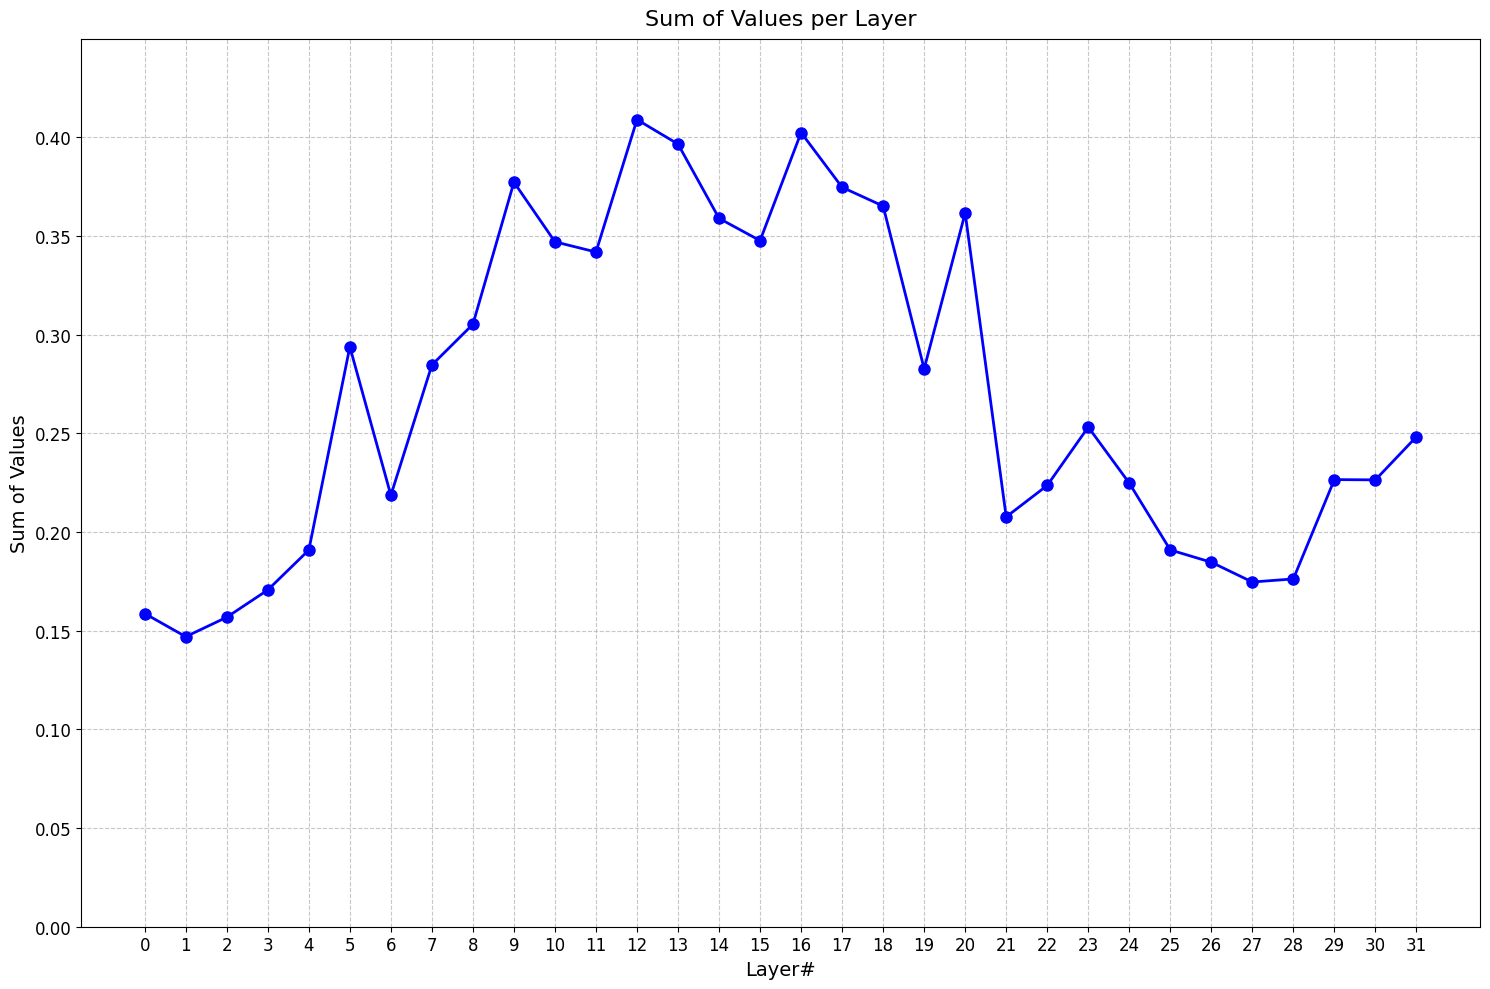

[np.float64(0.15872890419430202),
 np.float64(0.14699731104903752),
 np.float64(0.15686309585968652),
 np.float64(0.17068731702036327),
 np.float64(0.19091145197550458),
 np.float64(0.29391361338396865),
 np.float64(0.21864928967422909),
 np.float64(0.2846989548868603),
 np.float64(0.30532598743836087),
 np.float64(0.37735562088588875),
 np.float64(0.34712409476439154),
 np.float64(0.34194379465447533),
 np.float64(0.4090602298577627),
 np.float64(0.39665910932752824),
 np.float64(0.35901562372843426),
 np.float64(0.34773004717297024),
 np.float64(0.40248123639159733),
 np.float64(0.3747522044512961),
 np.float64(0.3652449854546123),
 np.float64(0.2827535793185234),
 np.float64(0.3617313885026508),
 np.float64(0.20771606183714336),
 np.float64(0.22363840954171285),
 np.float64(0.2532377772861057),
 np.float64(0.22482707268661922),
 np.float64(0.19095720599095029),
 np.float64(0.18473105877637863),
 np.float64(0.17470524625645745),
 np.float64(0.17626415524217817),
 np.float64(0.2266079

In [5]:
def plot_layer_sums(
    frequencies,
    base_width=15,
    base_height=10,
    line_color='blue',
    line_style='-',
    marker='o',
    base_title_fontsize=16,
    base_label_fontsize=14,
    base_tick_fontsize=12,
    output_path=None,
    output_format="svg",
    dpi=600,
    bbox_inches="tight"
):
    """
    Draws a line chart of the sum of values per layer.

    Parameters:
        frequencies (dict): Dictionary with layer indices as keys and numpy arrays as values.
        base_width (float): Base width of the plot in inches.
        base_height (float): Base height of the plot in inches.
        line_color (str): Color of the line.
        line_style (str): Line style (e.g., '-', '--', '-.', ':').
        marker (str): Marker style for data points (e.g., 'o', 's', '^').
        base_title_fontsize (int): Font size for the plot title.
        base_label_fontsize (int): Font size for axis labels.
        base_tick_fontsize (int): Font size for tick labels.
        output_path (str or Path): Path to save the plot and data. If None, only display.
        output_format (str): Format of the output file (e.g., "svg", "png").
        dpi (int): DPI for the saved figure.
        bbox_inches (str): Bounding box adjustment for saving.
    Returns:
        layer_sums (list): List of sums for each layer.
    """
    # 计算每一层的和
    layers = sorted(frequencies.keys())
    layer_sums = [np.sum(frequencies[layer]) for layer in layers]

    # 创建折线图
    fig, ax = plt.subplots(figsize=(base_width, base_height))
    ax.plot(layers, layer_sums, color=line_color, linestyle=line_style, marker=marker, linewidth=2, markersize=8)
    # 设置标题和标签
    ax.set_title("Sum of Values per Layer", fontsize=base_title_fontsize, pad=10)
    ax.set_xlabel("Layer#", fontsize=base_label_fontsize)
    ax.set_ylabel("Sum of Values", fontsize=base_label_fontsize)

    # 设置刻度和范围
    ax.set_xticks(layers)
    ax.set_ylim(0, max(layer_sums) * 1.1)
    ax.tick_params(axis='x', labelsize=base_tick_fontsize)
    ax.tick_params(axis='y', labelsize=base_tick_fontsize)
    ax.grid(True, linestyle='--', alpha=0.7)

    # 调整布局
    plt.tight_layout()

    # 保存图形和数据
    if output_path is not None:
        output_path = Path(output_path)
        output_dir = output_path.parent
        output_dir.mkdir(parents=True, exist_ok=True)

        # 保存折线图
        plt.savefig(output_path, format=output_format, dpi=dpi, bbox_inches=bbox_inches)

        # 保存数据为 JSON
        json_path = output_path.with_suffix('.json')
        with open(json_path, 'w') as f:
            json.dump({
                "layers": layers,
                "layer_sums": layer_sums
            }, f, indent=4)

    # 显示图形
    plt.show()
    return layer_sums
plot_layer_sums(frequencies2)

In [2]:
from tqdm import tqdm


def cache_process(model, tokenizer, texts, max_new_tokens, device="cuda"):
    """处理文本并收集缓存统计数据（LRU、FIFO、LFU等），按层存储总命中和请求次数"""
    
    # 初始化按层存储的总体统计
    overall_stats = {
        'lru': {
            'total_hits': {},  # {layer_idx: total_hits}
            'total_requests': {},  # {layer_idx: total_requests}
            'hit_rates': {},  # {layer_idx: hit_rate}
            'overall_hit_rate': 0.0
        },
        'fifo': {
            'total_hits': {},
            'total_requests': {},
            'hit_rates': {},
            'overall_hit_rate': 0.0
        },
        'lfu': {
            'total_hits': {},
            'total_requests': {},
            'hit_rates': {},
            'overall_hit_rate': 0.0
        },
        'lru_real': {
            'total_hits': {},
            'total_requests': {},
            'hit_rates': {},
            'overall_hit_rate': 0.0
        },
        'fifo_real': {
            'total_hits': {},
            'total_requests': {},
            'hit_rates': {},
            'overall_hit_rate': 0.0
        },
        'lfu_real': {
            'total_hits': {},
            'total_requests': {},
            'hit_rates': {},
            'overall_hit_rate': 0.0
        }
    }
    
    # 重置模型的所有缓存模拟器
    model.model.reset_all_cache_simulators()
    
    # 设置分词器的填充标记
    tokenizer.pad_token = tokenizer.eos_token
    
    for idx, text in enumerate(tqdm(texts, desc="Processing texts")):
        # 编码输入文本
        inputs = tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            padding_side='left',
            add_special_tokens=True
        )
        input_ids = inputs["input_ids"].to(device)
        
        # 打印输入形状
        print(f"idx: {idx}, input shape: {input_ids.shape}")
        
        # 生成输出
        with torch.no_grad():
            outputs = model.generate(
                input_ids,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.85,
                top_p=0.9,
                top_k=50,
                repetition_penalty=1.05
            )
            print(f"output shape: {outputs.shape}")
        
        # 检查输出是否过短
        if outputs.shape[1] - input_ids.shape[1] <= 1:
            print(f"Skipped - Text: {text}")
            output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            print(f"Output: {output_text}")
            continue
        
        # 收集缓存统计数据并累加到 overall_stats
        cache_types = [
            ('lru'      ,  model.model.get_all_lru_cache_stats),
            ('fifo'     ,  model.model.get_all_fifo_cache_stats),
            ('lfu'      ,  model.model.get_all_lfu_cache_stats),
            ('lru_real' ,  model.model.get_all_lru_cache_real_stats),
            ('fifo_real',  model.model.get_all_fifo_cache_real_stats),
            ('lfu_real' ,  model.model.get_all_lfu_cache_real_stats)
        ]
        
        for cache_type, get_stats_func in cache_types:
            try:
                stats = get_stats_func()
                # 累加每层的统计
                for layer_idx, layer_stats in stats.items():
                    if layer_idx not in overall_stats[cache_type]['total_hits']:
                        overall_stats[cache_type]['total_hits'][layer_idx] = 0
                        overall_stats[cache_type]['total_requests'][layer_idx] = 0
                    overall_stats[cache_type]['total_hits'][layer_idx] += layer_stats['hits']
                    overall_stats[cache_type]['total_requests'][layer_idx] += layer_stats['requests']
            except AttributeError:
                print(f"Warning: `{get_stats_func.__name__}` not found for run {idx}.")
        
    # 计算每层和整体的命中率
    for cache_type in overall_stats:
        total_hits_sum = sum(overall_stats[cache_type]['total_hits'].values())
        total_requests_sum = sum(overall_stats[cache_type]['total_requests'].values())
        overall_stats[cache_type]['overall_hit_rate'] = (
            total_hits_sum / total_requests_sum if total_requests_sum > 0 else 0.0
        )
        # 计算每层的命中率
        for layer_idx in overall_stats[cache_type]['total_hits']:
            hits = overall_stats[cache_type]['total_hits'][layer_idx]
            requests = overall_stats[cache_type]['total_requests'][layer_idx]
            if layer_idx not in overall_stats[cache_type]['hit_rates']:
                overall_stats[cache_type]['hit_rates'][layer_idx] = 0.0
            overall_stats[cache_type]['hit_rates'][layer_idx] = (
                hits / requests if requests > 0 else 0.0
            )
      
    # 打印每层和整体的命中率
    print("\n--- Overall Cache Statistics ---")
    for cache_type in overall_stats:
        print(f"\n{cache_type.upper()} Cache:")
        for layer_idx in sorted(overall_stats[cache_type]['total_hits'].keys()):
            print(f"  Layer {layer_idx}: Total Hits={overall_stats[cache_type]['total_hits'][layer_idx]}, "
                  f"Total Requests={overall_stats[cache_type]['total_requests'][layer_idx]}, "
                  f"Hit Rate={overall_stats[cache_type]['hit_rates'][layer_idx]:.4f}")
        print(f"  Overall: Total Hits={sum(overall_stats[cache_type]['total_hits'].values())}, "
              f"Total Requests={sum(overall_stats[cache_type]['total_requests'].values())}, "
              f"Hit Rate={overall_stats[cache_type]['overall_hit_rate']:.4f}")
    
    # 重置模型状态
    model.model.reset_all_cache_simulators()
    
    # 返回所有统计结果
    return (
        overall_stats
    )
all_texts=["Explain what an API is."]
result = cache_process(model, tokenizer, all_texts,256, device="cuda")

Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


idx: 0, input shape: torch.Size([1, 7])


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_output shape: torch.Size([1, 7, 64])
predictor_out

Processing texts: 100%|██████████| 1/1 [00:29<00:00, 29.81s/it]

predictor_output shape: torch.Size([1, 1, 64])
decode 阶段，layer_idx: 26, predictor_output[:,:,:].shape: torch.Size([1, 1, 64])
predictor_output shape: torch.Size([1, 1, 64])
decode 阶段，layer_idx: 1, predictor_output[:,:,:].shape: torch.Size([1, 1, 64])
predictor_output shape: torch.Size([1, 1, 64])
decode 阶段，layer_idx: 2, predictor_output[:,:,:].shape: torch.Size([1, 1, 64])
predictor_output shape: torch.Size([1, 1, 64])
decode 阶段，layer_idx: 3, predictor_output[:,:,:].shape: torch.Size([1, 1, 64])
predictor_output shape: torch.Size([1, 1, 64])
decode 阶段，layer_idx: 4, predictor_output[:,:,:].shape: torch.Size([1, 1, 64])
predictor_output shape: torch.Size([1, 1, 64])
decode 阶段，layer_idx: 5, predictor_output[:,:,:].shape: torch.Size([1, 1, 64])
predictor_output shape: torch.Size([1, 1, 64])
decode 阶段，layer_idx: 6, predictor_output[:,:,:].shape: torch.Size([1, 1, 64])
predictor_output shape: torch.Size([1, 1, 64])
decode 阶段，layer_idx: 7, predictor_output[:,:,:].shape: torch.Size([1, 1, 64])

In [3]:
import torch
from tqdm import tqdm
import copy
# ... existing code ...
# Assuming CacheSimulator class is defined in a previous cell or imported
# from models.DeepSeek_V2_Lite.cache_simulator import CacheSimulator 

test=[["Explain what an API is."]]
# test = [
#     [
#         {"role": "user", "content": "Please tell me a long story. long long ago:"},
#     ]
#     # 如果有更多的对话样本，可以像这样添加：
#     # [[{"role": "user", "content": "Hello"}, {"role": "assistant", "content": "Hi there!"}, {"role": "user", "content": "How are you?"}]],
# ]

# Reset the new cache simulators
if hasattr(model.model, "reset_all_cache_simulators"):
    print("Resetting LRU, FIFO, LFU cache simulators...")
    model.model.reset_all_cache_simulators()
elif hasattr(model, "reset_all_cache_simulators"): # Check on model directly if not on model.model
    print("Resetting LRU, FIFO, LFU cache simulators on model object...")
    model.reset_all_cache_simulators()
else:
    print("Warning: `reset_all_cache_simulators` method not found on model or model.model. Cache stats might be cumulative.")

# Dictionaries to store stats from the new cache simulators
lru_cache_stats_results = {}
fifo_cache_stats_results = {}
lfu_cache_stats_results = {}
lru_cache_real_stats_results = {}
fifo_cache_real_stats_results = {}
lfu_cache_real_stats_results = {}

tokenizer.pad_token = tokenizer.eos_token
# for idx in range(len(all_texts)): # If running for multiple texts
for idx in range(1): # Currently runs for one iteration as in your selection
    # text = all_texts[idx]
    text = test[0]
    model.model.reset_all_cache_simulators()
    
    
    inputs = tokenizer(text, return_tensors="pt",padding=True, truncation=True,padding_side='left',add_special_tokens=True)
    input_ids = inputs["input_ids"].to("cuda")
    # input_ids = tokenizer.apply_chat_template(
    #         text,
    #         add_generation_prompt=False, # 对于生成任务，这通常是必要的
    #         return_tensors="pt"
    #     ).to("cuda")
    #     # 为聊天模板生成的 input_ids 创建 attention_mask
    # attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=input_ids.device)

    print(f'idx:{idx}\ninput:{input_ids.shape}')
    # print(f'text:{text}')
    attention_mask = inputs["attention_mask"].to("cuda")
    # position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device).unsqueeze(0)

    with torch.no_grad():
        # outputs = model(input_ids, attention_mask=attention_mask, position_ids=position_ids)
        outputs = model.generate(input_ids, max_new_tokens=512, do_sample=True, temperature=0.85, top_p=0.9, top_k=50,repetition_penalty=1.05)
        print("output:",outputs.shape)
        # print(outputs[0])
        output_text = tokenizer.decode(outputs[0], skip_special_tokens=False)
        print(output_text)
            
    if outputs.shape[1]-input_ids.shape[1] <= 1:
        print(f"Skipping run {idx} due to short output for text: {text}")
        # output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # print(output_text)
        continue
        
    # Collect statistics from the cache simulators
    if hasattr(model.model, "get_all_lru_cache_stats"):
        lru_cache_stats_results[idx] = model.model.get_all_lru_cache_stats()
    else:
        print(f"Warning: `get_all_lru_cache_stats` not found for run {idx}.")

    if hasattr(model.model, "get_all_fifo_cache_stats"):
        fifo_cache_stats_results[idx] = model.model.get_all_fifo_cache_stats()
    else:
        print(f"Warning: `get_all_fifo_cache_stats` not found for run {idx}.")

    if hasattr(model.model, "get_all_lfu_cache_stats"):
        lfu_cache_stats_results[idx] = model.model.get_all_lfu_cache_stats()
    else:
        print(f"Warning: `get_all_lfu_cache_stats` not found for run {idx}.")

    if hasattr(model.model, "get_all_lru_cache_real_stats"):
        lru_cache_real_stats_results[idx] = model.model.get_all_lru_cache_real_stats()
    else:
        print(f"Warning: `get_all_lru_cache_real_stats` not found for run {idx}.")

    if hasattr(model.model, "get_all_fifo_cache_real_stats"):
        fifo_cache_real_stats_results[idx] = model.model.get_all_fifo_cache_real_stats()
    else:
        print(f"Warning: `get_all_fifo_cache_real_stats` not found for run {idx}.")
    
    if hasattr(model.model, "get_all_lfu_cache_real_stats"):
        lfu_cache_real_stats_results[idx] = model.model.get_all_lfu_cache_real_stats()
    else:
        print(f"Warning: `get_all_lfu_cache_real_stats` not found for run {idx}.")

# --- Reporting Cache Performance ---
print("\n--- Cache Performance Statistics ---")
# Assuming the loop runs for idx=0
run_idx_to_print = 0 # Change if your loop iterates more or differently

if run_idx_to_print in lru_cache_stats_results:
    print(f"\n--- LRU Cache Stats for Run {run_idx_to_print} ---")
    if lru_cache_stats_results[run_idx_to_print]:
        total_hits, total_requests = 0, 0
        for layer_idx, stats in lru_cache_stats_results[run_idx_to_print].items():
            print(f"  Layer {layer_idx}: Hits={stats['hits']}, Misses={stats['misses']}, Requests={stats['requests']}, Hit Rate={stats['hit_rate']:.4f}, Capacity={stats['capacity']}")
            total_hits += stats['hits']
            total_requests += stats['requests']
        if total_requests > 0:
            overall_hit_rate = total_hits / total_requests
            print(f"  Overall LRU Hit Rate for Run {run_idx_to_print}: {overall_hit_rate:.4f} (Hits: {total_hits}, Requests: {total_requests})")
        else:
            print(f"  No requests recorded for LRU in Run {run_idx_to_print}.")
    else:
        print(f"  LRU stats dictionary is empty for Run {run_idx_to_print}.")
else:
    print(f"  No LRU stats collected for Run {run_idx_to_print}.")
    
if run_idx_to_print in fifo_cache_stats_results:
    print(f"\n--- FIFO Cache Stats for Run {run_idx_to_print} ---")
    if fifo_cache_stats_results[run_idx_to_print]:
        total_hits, total_requests = 0, 0
        for layer_idx, stats in fifo_cache_stats_results[run_idx_to_print].items():
            print(f"  Layer {layer_idx}: Hits={stats['hits']}, Misses={stats['misses']}, Requests={stats['requests']}, Hit Rate={stats['hit_rate']:.4f}, Capacity={stats['capacity']}")
            total_hits += stats['hits']
            total_requests += stats['requests']
        if total_requests > 0:
            overall_hit_rate = total_hits / total_requests
            print(f"  Overall FIFO Hit Rate for Run {run_idx_to_print}: {overall_hit_rate:.4f} (Hits: {total_hits}, Requests: {total_requests})")
        else:
            print(f"  No requests recorded for FIFO in Run {run_idx_to_print}.")
    else:
        print(f"  FIFO stats dictionary is empty for Run {run_idx_to_print}.")
else:
    print(f"  No FIFO stats collected for Run {run_idx_to_print}.")

if run_idx_to_print in lfu_cache_stats_results:
    print(f"\n--- LFU Cache Stats for Run {run_idx_to_print} ---")
    if lfu_cache_stats_results[run_idx_to_print]:
        total_hits, total_requests = 0, 0
        for layer_idx, stats in lfu_cache_stats_results[run_idx_to_print].items():
            print(f"  Layer {layer_idx}: Hits={stats['hits']}, Misses={stats['misses']}, Requests={stats['requests']}, Hit Rate={stats['hit_rate']:.4f}, Capacity={stats['capacity']}")
            total_hits += stats['hits']
            total_requests += stats['requests']
        if total_requests > 0:
            overall_hit_rate = total_hits / total_requests
            print(f"  Overall LFU Hit Rate for Run {run_idx_to_print}: {overall_hit_rate:.4f} (Hits: {total_hits}, Requests: {total_requests})")
        else:
            print(f"  No requests recorded for LFU in Run {run_idx_to_print}.")
    else:
        print(f"  LFU stats dictionary is empty for Run {run_idx_to_print}.")
else:
    print(f"  No LFU stats collected for Run {run_idx_to_print}.")

if run_idx_to_print in lru_cache_real_stats_results:
    print(f"\n--- Real LRU Cache Stats for Run {run_idx_to_print} ---")
    if lru_cache_stats_results[run_idx_to_print]:
        total_hits, total_requests = 0, 0
        for layer_idx, stats in lru_cache_real_stats_results[run_idx_to_print].items():
            print(f"  Layer {layer_idx}: Hits={stats['hits']}, Misses={stats['misses']}, Requests={stats['requests']}, Hit Rate={stats['hit_rate']:.4f}, Capacity={stats['capacity']}")
            total_hits += stats['hits']
            total_requests += stats['requests']
        if total_requests > 0:
            overall_hit_rate = total_hits / total_requests
            print(f"  Overall Real LRU Hit Rate for Run {run_idx_to_print}: {overall_hit_rate:.4f} (Hits: {total_hits}, Requests: {total_requests})")
        else:
            print(f"  No requests recorded for Real LRU in Run {run_idx_to_print}.")
    else:
        print(f"  Real LRU stats dictionary is empty for Run {run_idx_to_print}.")
else:
    print(f"  No Real LRU stats collected for Run {run_idx_to_print}.")

if run_idx_to_print in fifo_cache_real_stats_results:
    print(f"\n--- Real FIFO Cache Stats for Run {run_idx_to_print} ---")
    if fifo_cache_real_stats_results[run_idx_to_print]:
        total_hits, total_requests = 0, 0
        for layer_idx, stats in fifo_cache_real_stats_results[run_idx_to_print].items():
            print(f"  Layer {layer_idx}: Hits={stats['hits']}, Misses={stats['misses']}, Requests={stats['requests']}, Hit Rate={stats['hit_rate']:.4f}, Capacity={stats['capacity']}")
            total_hits += stats['hits']
            total_requests += stats['requests']
        if total_requests > 0:
            overall_hit_rate = total_hits / total_requests
            print(f"  Overall Real FIFO Hit Rate for Run {run_idx_to_print}: {overall_hit_rate:.4f} (Hits: {total_hits}, Requests: {total_requests})")
        else:
            print(f"  No requests recorded for Real FIFO in Run {run_idx_to_print}.")
    else:
        print(f"  Real FIFO stats dictionary is empty for Run {run_idx_to_print}.")
else:
    print(f"  No Real FIFO stats collected for Run {run_idx_to_print}.")

if run_idx_to_print in lfu_cache_real_stats_results:
    print(f"\n--- Real LFU Cache Stats for Run {run_idx_to_print} ---")
    if lfu_cache_real_stats_results[run_idx_to_print]:
        total_hits, total_requests = 0, 0
        for layer_idx, stats in lfu_cache_real_stats_results[run_idx_to_print].items():
            print(f"  Layer {layer_idx}: Hits={stats['hits']}, Misses={stats['misses']}, Requests={stats['requests']}, Hit Rate={stats['hit_rate']:.4f}, Capacity={stats['capacity']}")
            total_hits += stats['hits']
            total_requests += stats['requests']
        if total_requests > 0:
            overall_hit_rate = total_hits / total_requests
            print(f"  Overall Real LFU Hit Rate for Run {run_idx_to_print}: {overall_hit_rate:.4f} (Hits: {total_hits}, Requests: {total_requests})")
        else:
            print(f"  No requests recorded for Real LFU in Run {run_idx_to_print}.")
    else:
        print(f"  Real LFU stats dictionary is empty for Run {run_idx_to_print}.")
else:
    print(f"  No Real LFU stats collected for Run {run_idx_to_print}.")



Resetting LRU, FIFO, LFU cache simulators...
idx:0
input:torch.Size([1, 7])
output: torch.Size([1, 89])
Explain what an API is. An API, or Application Programming Interface, is a set of rules and protocols that allow different software applications to communicate with each other. APIs provide a way for developers to access certain functionalities or data from another application without having to build those features from scratch. They can be used for a variety of purposes, such as integrating third-party services into an application, accessing external databases, or retrieving information from the internet.<|endoftext|>

--- Cache Performance Statistics ---

--- LRU Cache Stats for Run 0 ---
  Layer 0: Hits=63, Misses=261, Requests=324, Hit Rate=0.1944, Capacity=15
  Layer 1: Hits=91, Misses=233, Requests=324, Hit Rate=0.2809, Capacity=15
  Layer 2: Hits=90, Misses=234, Requests=324, Hit Rate=0.2778, Capacity=15
  Layer 3: Hits=98, Misses=226, Requests=324, Hit Rate=0.3025, Capacity=1

Max tokens available: 510
0.5870834


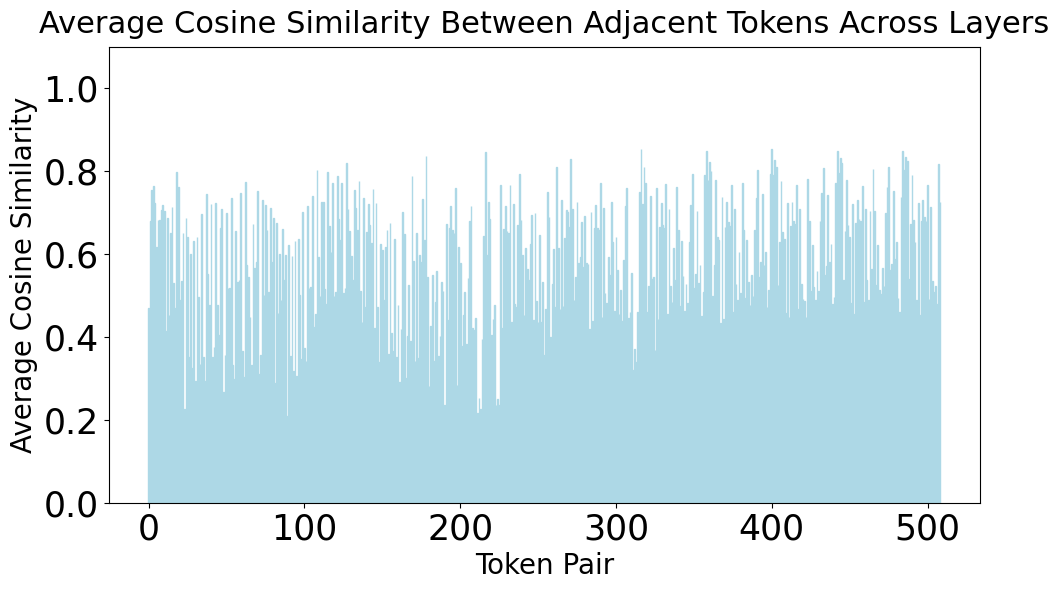

In [9]:
def plot_cosine_similarity_grid(
    frequencies,
    layers=range(0, 32),
    token_start=1,
    token_end=None,
    base_width=10,  # 整体图的基准宽度（英寸）
    base_height=6,  # 整体图的基准高度（英寸）
    bar_color='lightblue',
    bar_edgecolor='lightblue',
    bar_width=0.5,
    y_ticks=np.arange(0, 1.2, 0.2),
    base_title_fontsize=22,
    base_label_fontsize=20,
    base_tick_fontsize=25,
    output_path=None,
    output_format="svg",
    dpi=600,
    bbox_inches="tight"
):
    """
    Plots a bar chart of average cosine similarity between adjacent tokens across all specified layers.

    Parameters:
        frequencies (dict): A nested dictionary containing frequency data, e.g., {layer_idx: {'routed': [token_0, token_1, ...]}}.
        layers (iterable): The layers to consider for similarity computation.
        token_start (int): Start index of the token range (inclusive).
        token_end (int): End index of the token range (exclusive). If None, defaults to max available tokens.
        base_width (float): Width of the plot in inches.
        base_height (float): Height of the plot in inches.
        bar_color (str): Color of the bars.
        bar_edgecolor (str): Edge color of the bars.
        bar_width (float): Width of the bars.
        y_ticks (array-like): Y-axis ticks for the plot.
        base_title_fontsize (int): Font size for the plot title.
        base_label_fontsize (int): Font size for axis labels.
        base_tick_fontsize (int): Font size for tick labels.
        output_path (str): Path to save the output figure.
        output_format (str): Format of the output file (e.g., "svg", "png").
        dpi (int): DPI for the saved figure.
        bbox_inches (str): Bounding box adjustment for saving the figure.
    """
    # 确定 token 范围
    max_tokens = len(frequencies[list(frequencies.keys())[0]]['routed']) - 1
    print(f"Max tokens available: {max_tokens}")
    token_end = min(token_end or max_tokens, max_tokens)
    token_range = range(token_start, token_end)  # token_start 到 token_end-1
    num_pairs = len(token_range)

    if num_pairs < 1:
        raise ValueError("Token range is too small. Need at least 2 tokens to compute similarity.")

    # 计算每对相邻 token 的平均余弦相似度
    avg_similarities = []
    for j in token_range:
        layer_similarities = []
        for i in layers:
            similarity = cosine_similarity_scipy(
                frequencies[i]['routed'][j],
                frequencies[i]['routed'][j + 1]
            )
            layer_similarities.append(similarity)
        # 计算当前 token 对在所有层的平均相似度
        avg_similarity = np.mean(layer_similarities)
        avg_similarities.append(avg_similarity)

    # 创建柱状图
    fig, ax = plt.subplots(figsize=(base_width, base_height))
    
    # X 轴：相邻 token 对的标签，例如 "1-2", "2-3"
    x_labels = [f"{j}-{j+1}" for j in token_range]
    x_positions = np.arange(len(token_range))
    print(np.mean(avg_similarities))
    # 绘制柱状图
    ax.bar(x_positions, avg_similarities, color=bar_color, edgecolor=bar_edgecolor, width=bar_width)
    ax.set_title("Average Cosine Similarity Between Adjacent Tokens Across Layers", 
                 fontsize=base_title_fontsize, pad=10)
    ax.set_xlabel("Token Pair", fontsize=base_label_fontsize)
    ax.set_ylabel("Average Cosine Similarity", fontsize=base_label_fontsize)
    ax.set_ylim(0, 1.1)
    # ax.set_xlim(0, 512)
    ax.set_yticks(y_ticks)
    # ax.set_xticks(x_positions)
    # ax.set_xticklabels(x_labels, rotation=45, ha='right')  # 旋转标签以避免重叠
    ax.tick_params(axis='x', labelsize=base_tick_fontsize)
    ax.tick_params(axis='y', labelsize=base_tick_fontsize)

    # 调整布局
    plt.tight_layout()

    # 保存图像
    if output_path is not None:
        plt.savefig(output_path, format=output_format, dpi=dpi, bbox_inches=bbox_inches)
    
    plt.show()
plot_cosine_similarity_grid(frequencies4[idx],layers=range(1,27),token_start=1,token_end=512)



# 数据分析

## 相似度分析

In [29]:
len(frequencies4[16][list(frequencies4[16].keys())[0]]['routed']) - 1

198

In [ ]:
# plot_cosine_similarity_grid(frequencies3,layers=range(0,32),token_start=1,token_end=1,max_cols=5)
# draw(frequencies1,title="Expert Activation Heatmap",output_path="/home/fit/renju/WORK/lxm/results_temp/figures/Request_level/qwen/qwen.svg")
draw(frequencies3[0],title="Cache hit rate")
draw(frequencies3[1],title="Cache hit rate")
draw_batch(frequencies3,title="Cache hit rate")
# plot_cosine_similarity_avg_cross_batch(frequencies4,layers=range(0,24),token_start=1,token_end=10000,output_path="/home/fit/renju/WORK/lxm/results_temp/figures/Token_level/qwen/qwen_simi_avg.svg")

## 比较

In [ ]:
import json
import matplotlib.pyplot as plt

# 文件列表（假设你有多个 JSON 文件）
json_files = ["/home/fit/renju/WORK/lxm/results_temp/figures/Token_level/deepseek/deepseek.json", 
              "/home/fit/renju/WORK/lxm/results_temp/figures/Token_level/mxitral/mixtral.json", 
              "/home/fit/renju/WORK/lxm/results/figures/phi/phi_simi_avg.json",
              "/home/fit/renju/WORK/lxm/results_temp/figures/Token_level/qwen/qwen_simi_avg.json",
              ]  # 请替换为实际文件名

# 颜色列表，用于区分不同文件的数据
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # 可根据需要扩展

# 创建图形
plt.figure(figsize=(10, 6))  # 设置图形大小

# 遍历每个 JSON 文件并绘制折线图
for idx, file_name in enumerate(json_files):
    try:
        # 读取 JSON 文件
        with open(file_name, 'r') as f:
            data = json.load(f)
        
        # 提取 layers 和 similarities
        layers = data["layers"]
        similarities = data["similarities"]
        
        # 绘制折线图
        plt.plot(layers, similarities, 
                color=colors[idx % len(colors)],  # 循环使用颜色
                label=file_name.split('/')[-2],                  # 图例显示文件名
                marker='o')                       # 添加数据点标记
    except FileNotFoundError:
        print(f"文件 {file_name} 未找到，跳过。")
    except KeyError as e:
        print(f"文件 {file_name} 格式错误，缺少字段 {e}，跳过。")

# 设置图形属性
plt.xlabel("Layers")            # 横轴标签
plt.ylabel("Cosine Similarity")        # 纵轴标签
plt.title("Expert activation similarity between adjacent tokens")  # 图标题
plt.legend()                    # 显示图例
plt.grid(True)                  # 添加网格线，便于观察

# 显示图形
plt.show()

## 上下文分析

In [10]:
# model.reset_all_expert_counts()
# model.reset_all_expert_continue()
# model.reset_all_expert_hit_rate()

# texts = ["Craft a concise technical piece on artificial intelligence.", "Outline the future trajectory of artificial intelligence."]
# texts = ["Give three tips for staying healthy.", "Describe the structure of an atom."]

# 保存上一次的输出，初始为空
previous_output = ""

# 创建激活概率矩阵
activation_matrix = np.zeros((len(all_texts),32, 16))
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})
for text_idx in range(len(all_texts)):
# for idx in range(1):
    print(f'text_idx:{text_idx}')
    input_text = all_texts[text_idx]
    if not input_text.strip():  # 跳过空文本
        continue
    model.reset_all_expert_counts()
    # model.reset_all_expert_continue()
    # model.reset_all_expert_hit_rate()
    # 如果是第一次循环，直接使用原始 Prompt
    # 如果是第二次循环，拼接上一次的输出和当前 Prompt
    # if text_idx == 0:
    #     input_text = text
    # else:
    #     input_text = previous_output + ".\n" + text  # 拼接上一次输出和当前 Prompt

    # 编码输入文本
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs["input_ids"].to("cuda")
    print(input_ids.shape)
    # attention_mask = inputs["attention_mask"].to("cuda")
    # position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device).unsqueeze(0)

    with torch.no_grad():
        # 使用 model.generate 生成输出
        outputs = model.generate(input_ids, max_new_tokens=200)
        print(outputs.shape)
        # output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # print(output_text)

    frequencies1 = model.get_all_expert_frequencies()
     # 确定 MoE 层数和专家数量
    # draw(frequencies1,title="Expert Activation Heatmap")

    # 填充矩阵
    experts_i = frequencies1[1]["routed"].keys()
    layer_counter = 0
    for layer_idx in sorted(frequencies1.keys()):
        # if layer_idx == 0:  # 跳过第 0 层（非 MoE 层）
        #     continue
        for expert_idx in experts_i:
            activation_matrix[text_idx,layer_counter, expert_idx] = frequencies1[layer_idx]["routed"][expert_idx]
        layer_counter+=1
    # frequencies2 = model.get_all_expert_continue()
    # frequencies3 = model.get_all_expert_hit_rate()
    # draw(frequencies1,f'Request{text_idx}')      
    # draw(frequencies3,"Token Level")     
    # 保存当前输出供下一次使用
    # previous_output = output_text

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


text_idx:0
torch.Size([1, 23])
torch.Size([1, 131])
text_idx:1
torch.Size([1, 33])
torch.Size([1, 45])
text_idx:2
torch.Size([1, 8])
torch.Size([1, 208])
text_idx:3
torch.Size([1, 18])
torch.Size([1, 218])
text_idx:4
torch.Size([1, 41])
torch.Size([1, 241])
text_idx:5
torch.Size([1, 27])
torch.Size([1, 44])
text_idx:6
torch.Size([1, 28])
torch.Size([1, 32])
text_idx:7
torch.Size([1, 14])
torch.Size([1, 214])
text_idx:8
torch.Size([1, 34])
torch.Size([1, 135])
text_idx:9
torch.Size([1, 25])
torch.Size([1, 52])
text_idx:10
torch.Size([1, 11])
torch.Size([1, 211])
text_idx:11
torch.Size([1, 23])
torch.Size([1, 37])
text_idx:12
torch.Size([1, 7])
torch.Size([1, 207])
text_idx:13
torch.Size([1, 14])
torch.Size([1, 214])
text_idx:14
torch.Size([1, 10])
torch.Size([1, 181])
text_idx:15
torch.Size([1, 31])
torch.Size([1, 227])
text_idx:16
torch.Size([1, 23])
torch.Size([1, 223])
text_idx:17
torch.Size([1, 19])
torch.Size([1, 49])
text_idx:18
torch.Size([1, 15])
torch.Size([1, 215])
text_idx:19

Average Cosine Similarity for layer 0: 0.8546213623460147
Average Cosine Similarity for layer 1: 0.8152483462650542
Average Cosine Similarity for layer 2: 0.8313317857483148
Average Cosine Similarity for layer 3: 0.8218789764578639
Average Cosine Similarity for layer 4: 0.7743546739604813
Average Cosine Similarity for layer 5: 0.8034182559940314
Average Cosine Similarity for layer 6: 0.6633621851931273
Average Cosine Similarity for layer 7: 0.7952288664522977
Average Cosine Similarity for layer 8: 0.6338939416043261
Average Cosine Similarity for layer 9: 0.6599911218841956
Average Cosine Similarity for layer 10: 0.5010290681554301
Average Cosine Similarity for layer 11: 0.5880817557101836
Average Cosine Similarity for layer 12: 0.6274438246626907
Average Cosine Similarity for layer 13: 0.6145514785055096
Average Cosine Similarity for layer 14: 0.4862932334720995
Average Cosine Similarity for layer 15: 0.48865068639127696
Average Cosine Similarity for layer 16: 0.6296363848484249
Averag

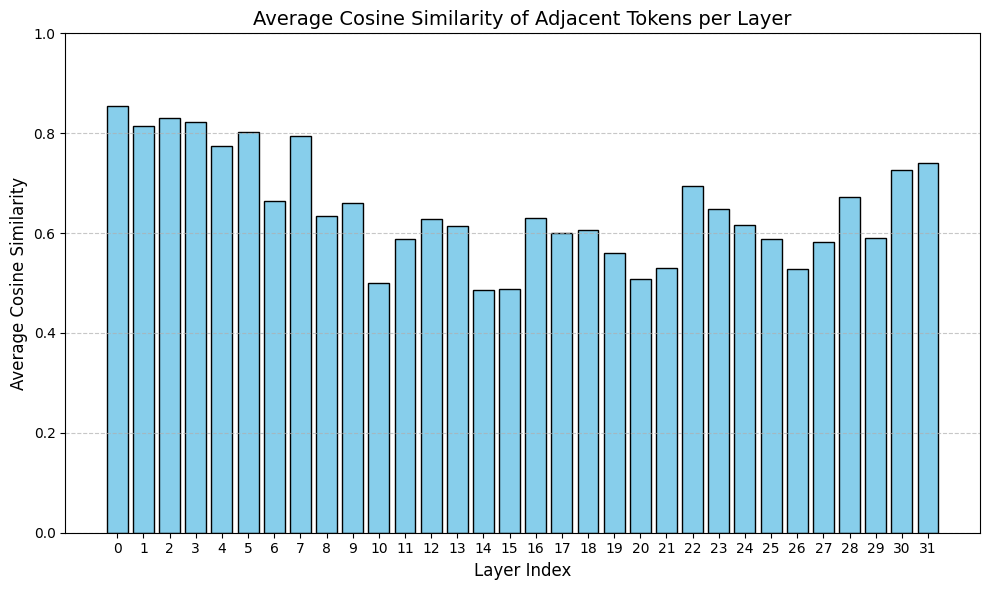

In [11]:
plot_layer_token_similarity_bar(activation_matrix,output_path="/home/fit/renju/WORK/lxm/results_temp/figures/Sentence_level/phi/phi.svg")